In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2Model

model_name = 'openai-community/gpt2-xl'#'openai-community/gpt2-large'#'gpt2'

# Load the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2Model.from_pretrained(model_name)


# Sample input text
text = "The skater was about to Jump and do a 360"

# Tokenize the input text
inputs = tokenizer(text, return_tensors='pt')
input_ids = inputs['input_ids']

In [2]:
# Get the token embeddings
with torch.no_grad():
    outputs = model(input_ids,output_attentions=True)
    # token_embeddings = outputs.last_hidden_state.squeeze().numpy()

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


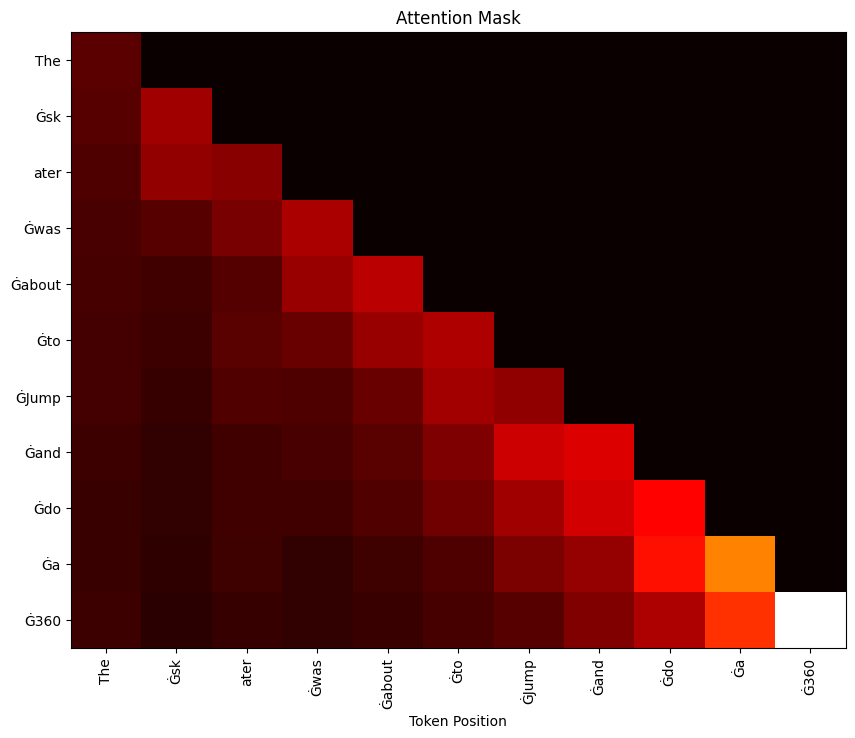

In [3]:


# Get the attention mask
attention_mask = torch.concat(outputs['attentions'],0).mean([0,1]).numpy()
attention_mask = attention_mask/attention_mask.mean(0)

# Visualize the attention mask
plt.figure(figsize=(10, 8))
plt.imshow(attention_mask, cmap='hot', aspect='auto')
plt.title('Attention Mask')
plt.xlabel('Token Position')
plt.xticks(ticks=np.arange(len(input_ids[0])), labels=tokenizer.convert_ids_to_tokens(input_ids[0]), rotation=90)
plt.yticks(ticks=np.arange(len(input_ids[0])), labels=tokenizer.convert_ids_to_tokens(input_ids[0]))
plt.show()

# Distances in Embedded space? 
attemtempting to copy an idea from 3blue1brown

In [4]:
tokenizer.vocab_size

50257

In [5]:
model.base_model.wte.weight.shape

torch.Size([50257, 1600])

In [6]:
tokenizer("hello")

{'input_ids': [31373], 'attention_mask': [1]}

In [7]:
tokenizer.decode([31373])

'hello'

In [8]:
#tokenizer.decoder

In [9]:
#dir(model.base_model.wte)

In [10]:
@torch.no_grad
def get_tok_embedding(text):
    toks=tokenizer.encode(text,return_tensors='pt')
    return model.base_model.wte(toks).mean(0)

In [11]:
@torch.no_grad
def get_similar_tokens(x,k=2):
    distances = torch.sum((model.base_model.wte.weight - x) ** 2, dim=1)
    _, indices = torch.topk(distances, k, largest=False, sorted=True)
    
    return [tokenizer.decoder[i] for i in indices.numpy()]

#tok=tokenizer.encode("hello",return_tensors='pt')[0]
x=get_tok_embedding("hello")
get_similar_tokens(x)#(model.base_model.wte(tok))

['hello', 'Hello']

In [12]:
tokenizer.encode("waiter")

[10247, 2676]

In [51]:
female=get_tok_embedding("girl")-get_tok_embedding("boy")
get_similar_tokens(get_tok_embedding("uncle")+female,3)

['uncle', 'girl', 'Ġaunt']

## now we move to higher order

In [45]:
def get_embedding_at(text,k=0):
    with torch.no_grad():
        outputs = model(**tokenizer(text, return_tensors='pt'),output_hidden_states=True)
        outputs=torch.concat(outputs['hidden_states'],0).mean(1)
        return outputs[k]

out=get_embedding_at("hello world")
# torch.stack(out['hidden_states']).shape
out.shape

torch.Size([1600])

In [48]:
(get_embedding_at('girl')-get_tok_embedding("girl")).abs().mean()/get_tok_embedding("girl").abs().mean()

tensor(0.5186)

In [128]:
def girl_test(k=0):
    female=get_embedding_at("girl",k)-get_embedding_at("boy",k)
    return get_similar_tokens(get_embedding_at("uncle",k)+female,3)

girl_test()

['uncle', 'girl', 'Ġaunt']

In [133]:
# get_similar_tokens(get_embedding_at("uncle",2),3)

In [121]:
num_blocks=len(model.base_model.h)+1
num_blocks

49

In [64]:
for i in range(3):
    print(f'girl test for {i} is {girl_test(i)}')

girl test for 0 is ['uncle', 'girl', 'Ġaunt']
girl test for 1 is ['uncle', 'apolis', 'Ġdrill']
girl test for 2 is ['Ġchef', 'uncle', 'ĠCA']


In [70]:
#now lets speed it up so its not painfully slow
def get_embedding_full(text):
    with torch.no_grad():
        outputs = model(**tokenizer(text, return_tensors='pt'),output_hidden_states=True)
        outputs=torch.concat(outputs['hidden_states'],0).mean(1)#alowing longer phrases
        return outputs

girl_embs=get_embedding_full('girl')
boy_embs=get_embedding_full('boy')
uncle_embs=get_embedding_full('uncle')

girl_embs.shape

torch.Size([49, 1600])

In [71]:
def girl_test(k=0):
    female=girl_embs[k]-boy_embs[k]
    return get_similar_tokens(uncle_embs[k]+female,3)

girl_test()

['uncle', 'girl', 'Ġaunt']

In [72]:
for i in range(num_blocks):
    print(f'girl test for {i} is {girl_test(i)}')

girl test for 0 is ['uncle', 'girl', 'Ġaunt']
girl test for 1 is ['uncle', 'apolis', 'Ġdrill']
girl test for 2 is ['Ġchef', 'uncle', 'ĠCA']
girl test for 3 is ['Ġchef', 'ĠBeef', 'uncle']
girl test for 4 is ['ĠGrace', 'ĠCap', 'ĠEvil']
girl test for 5 is ['ĠGrace', 'ĠMary', 'ĠCap']
girl test for 6 is ['ĠGrace', 'ĠCap', 'ĠMary']
girl test for 7 is ['ĠCarbuncle', 'ĠGrace', '":["']
girl test for 8 is ['://', ':{', '":"']
girl test for 9 is ['://', 'clips', ':{']
girl test for 10 is ['://', 'clips', ':{']
girl test for 11 is ['://', 'clips', ':{']
girl test for 12 is ['://', 'clips', ':{']
girl test for 13 is ['://', 'clips', ':{']
girl test for 14 is ['://', 'clips', ':{']
girl test for 15 is ['://', 'clips', ':{']
girl test for 16 is ['://', 'clips', ':{']
girl test for 17 is ['://', 'clips', ':{']
girl test for 18 is ['://', 'clips', ':{']
girl test for 19 is ['://', 'clips', ':{']
girl test for 20 is ['://', 'clips', ':{']
girl test for 21 is ['://', 'clips', ':{']
girl test for 22 is ['

# distances between short phrases

now we need to show distances between sentances
any ideas???

In [76]:
def get_embedding(text):
    with torch.no_grad():
        outputs = model(**tokenizer(text, return_tensors='pt'))
        return outputs.last_hidden_state.mean([0,1])

emb=get_embedding("hello world")
emb.shape

torch.Size([1600])

In [100]:
#phrases = ["breaking bad","hot dog","skating dog","teacher cat","algebra class","calculus lecture"]
phrases = ['girl','boy','uncle',"skating dog","teacher cat","algebra class","calculus lecture"]


In [101]:
#!pip install scikit-learn

In [102]:
from sklearn.metrics.pairwise import cosine_similarity

phrases_embeddings=np.stack([get_embedding(t) for t in phrases])
cosine_similarities = cosine_similarity(phrases_embeddings)#-np.eye(len(phrases))

In [103]:
# outputs.attentions.shape

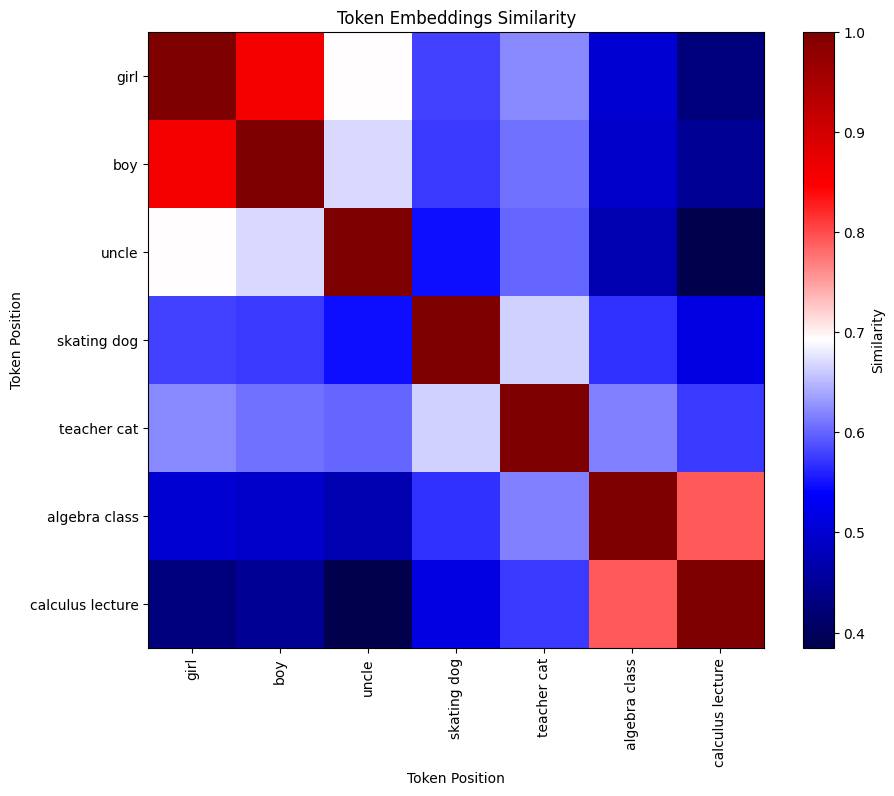

In [104]:
# Visualize token embeddings distances
plt.figure(figsize=(10, 8))
plt.imshow(cosine_similarities, cmap='seismic')#,vmin=0,vmax=1)
plt.colorbar(label='Similarity')
plt.title('Token Embeddings Similarity')
plt.xlabel('Token Position')
plt.ylabel('Token Position')
plt.xticks(ticks=np.arange(len(phrases)), labels=phrases, rotation=90)
plt.yticks(ticks=np.arange(len(phrases)), labels=phrases)
plt.show()

In [105]:
def get_embedding_full(text):
    with torch.no_grad():
        outputs = model(**tokenizer(text, return_tensors='pt'),output_hidden_states=True)
        outputs=torch.concat(outputs['hidden_states'],0).mean(1)
        #outputs=torch.concat(outputs['hidden_states'],1).mean(0)
        return outputs#.last_hidden_state.mean([0])

out=get_embedding_full("hello world")
# torch.stack(out['hidden_states']).shape
out.shape

torch.Size([49, 1600])

In [106]:
embs=torch.stack([get_embedding_full(t) for t in phrases]).transpose(0,1)
embs.shape

torch.Size([49, 7, 1600])

In [107]:
cosine_similarities=np.stack([cosine_similarity(layer_embs) for layer_embs in embs])
# for c in cosine_similarities:
#     print(c.std())
c.std(1).mean()

0.18968342

In [108]:
embs.std(1).mean()

tensor(2.6826)

In [109]:
min_val=cosine_similarities.min();max_val=cosine_similarities.max()
min_val,max_val

(0.3847248, 1.0000006)

In [110]:
cosine_similarities.mean(),cosine_similarities.std()

(0.93545955, 0.13067679)

In [111]:
#norm_sims=(cosine_similarities-cosine_similarities.mean())/cosine_similarities.std()

In [112]:
def make_dist_plot(cs,anim=False):
    #cosine_similarities=cosine_similarity(x)
    # Visualize token embeddings distances
    im=plt.imshow(cs, cmap='seismic',animated=anim)
    plt.colorbar(label='Similarity')
    plt.title('Token Embeddings Similarity')
    plt.xlabel('Token Position')
    plt.ylabel('Token Position')
    plt.xticks(ticks=np.arange(len(phrases)), labels=phrases, rotation=90)
    plt.yticks(ticks=np.arange(len(phrases)), labels=phrases)
    plt.show()
    return im

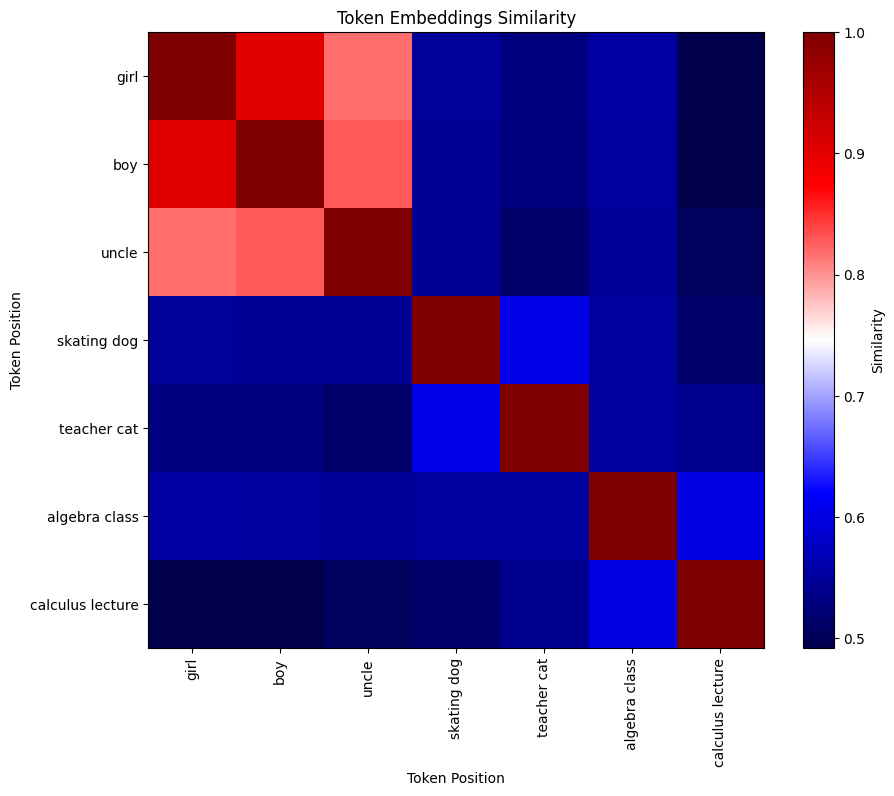

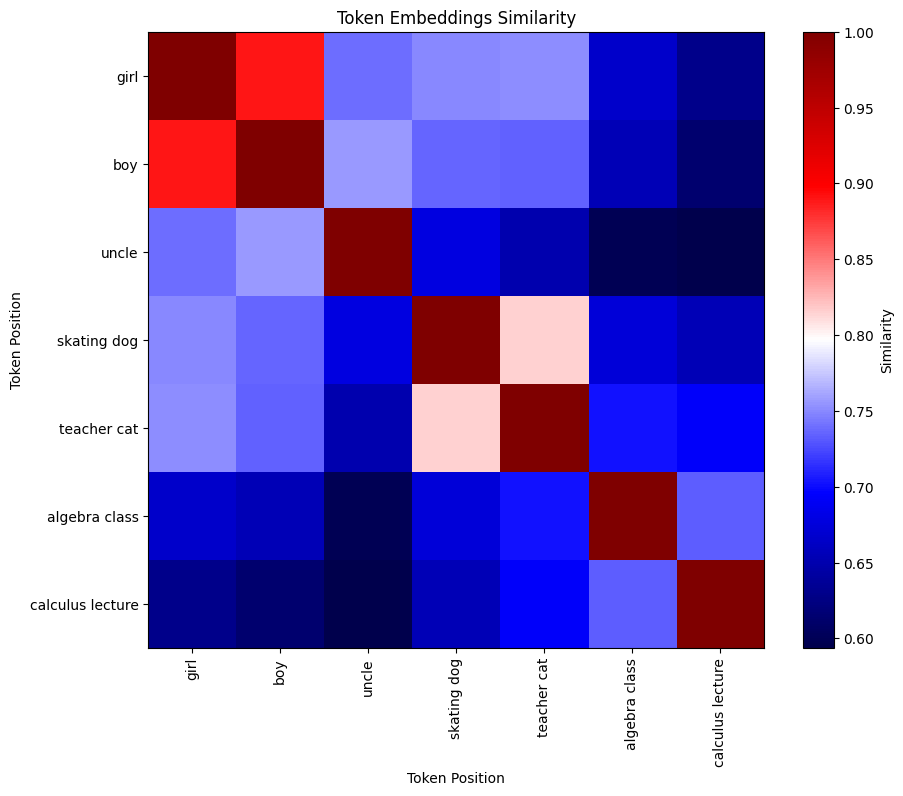

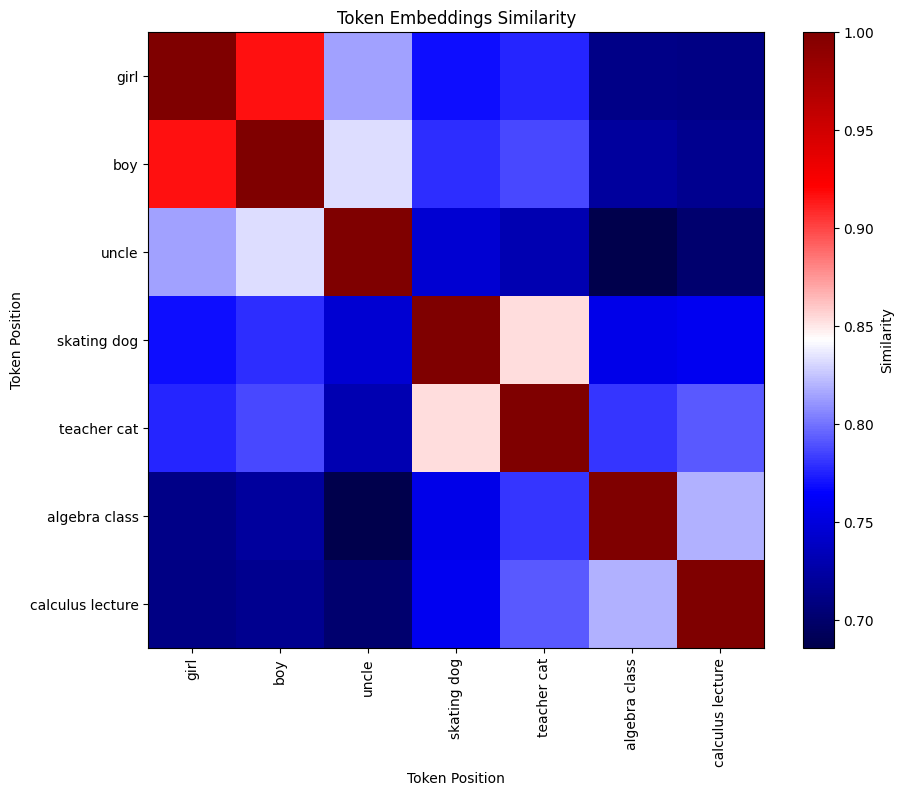

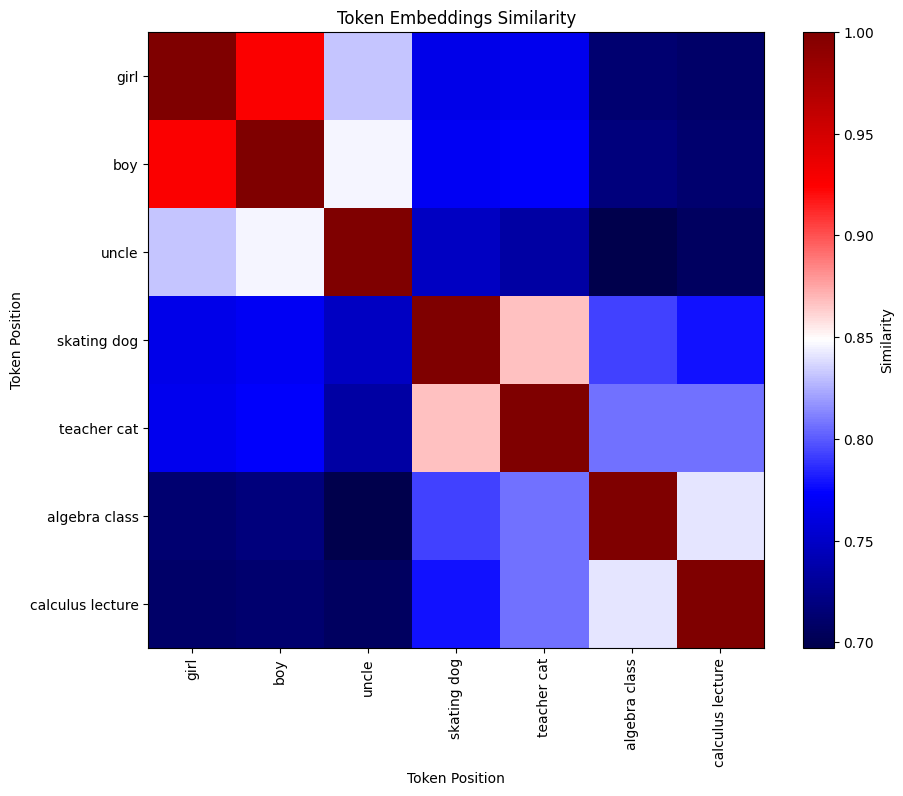

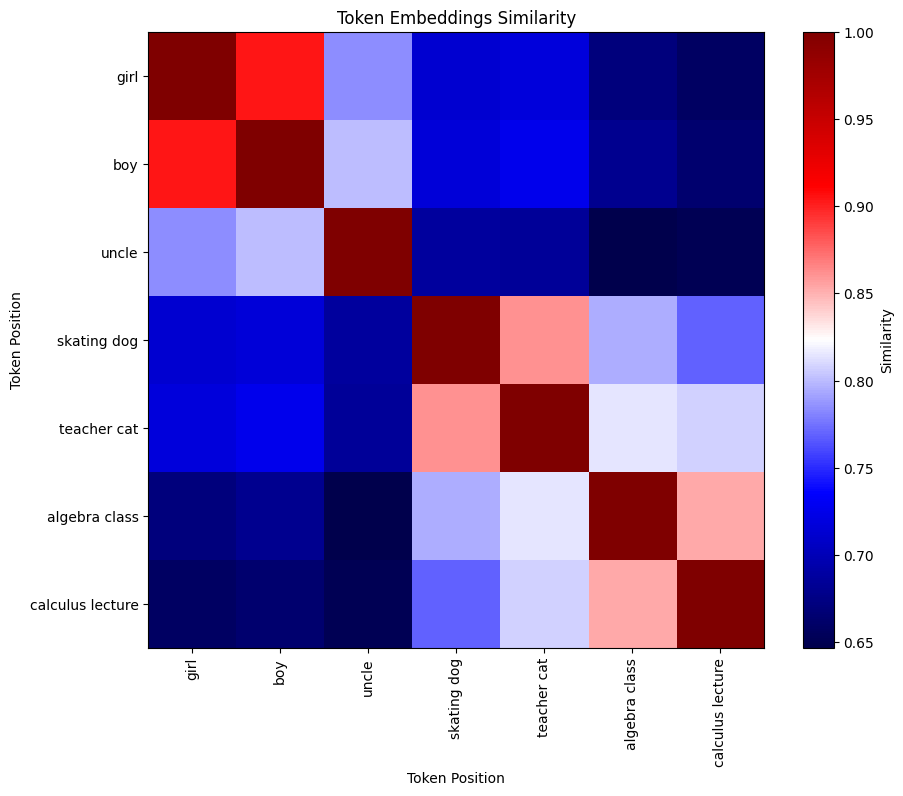

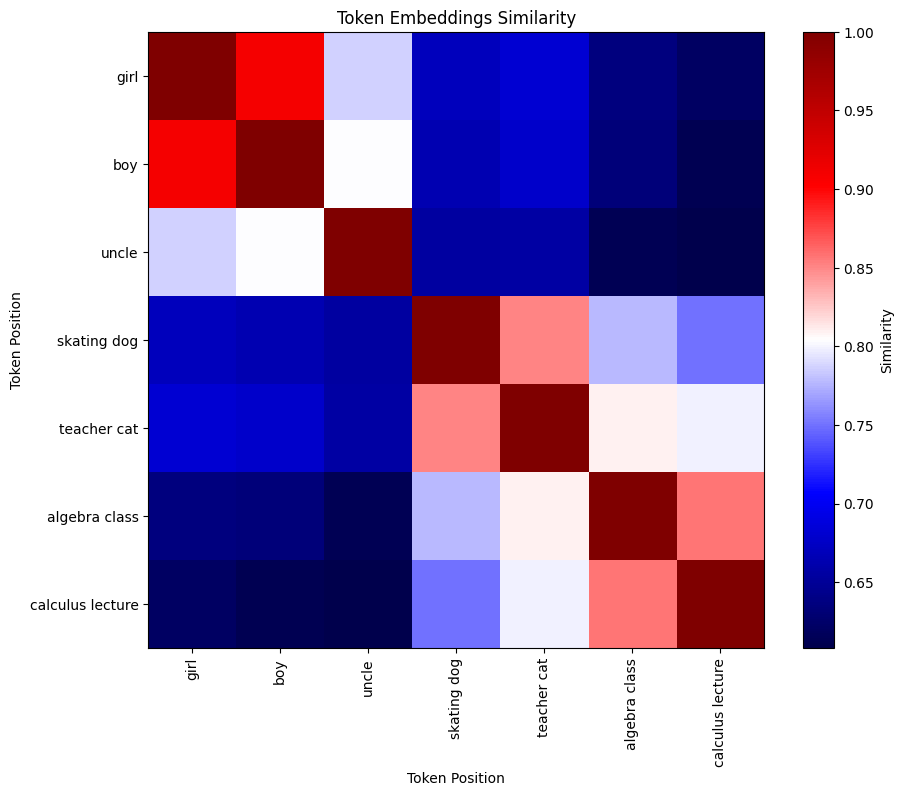

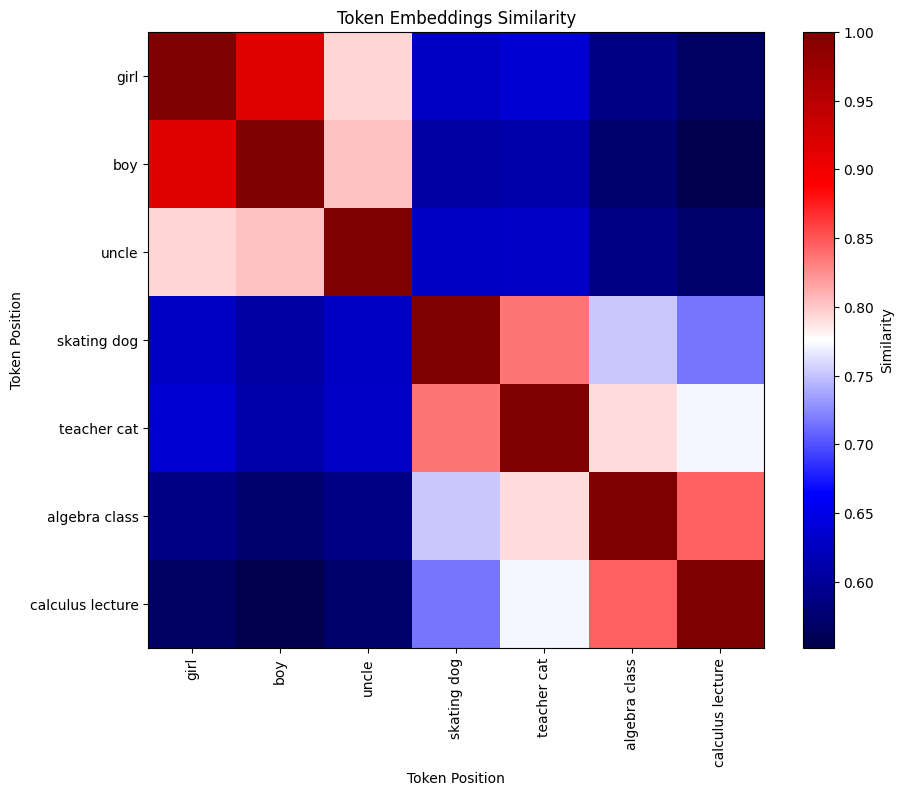

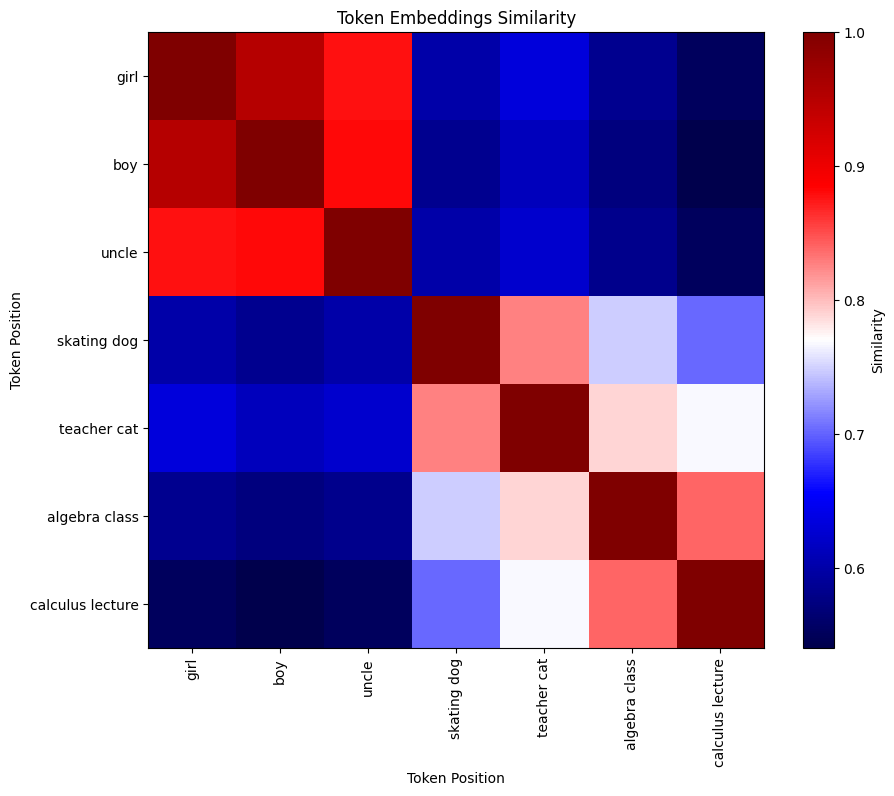

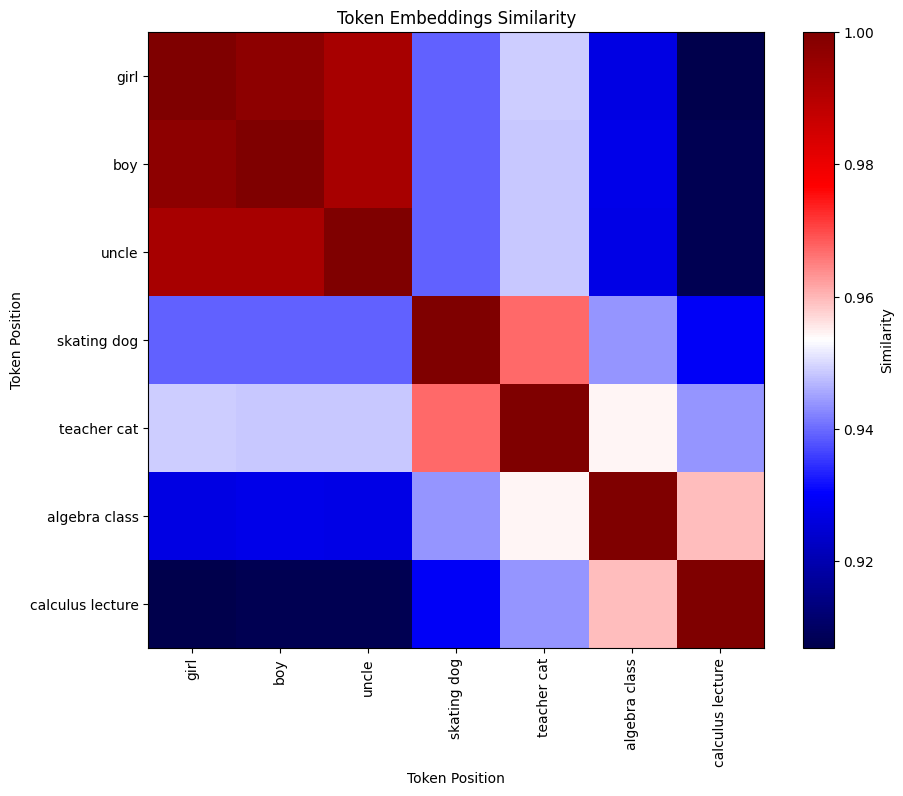

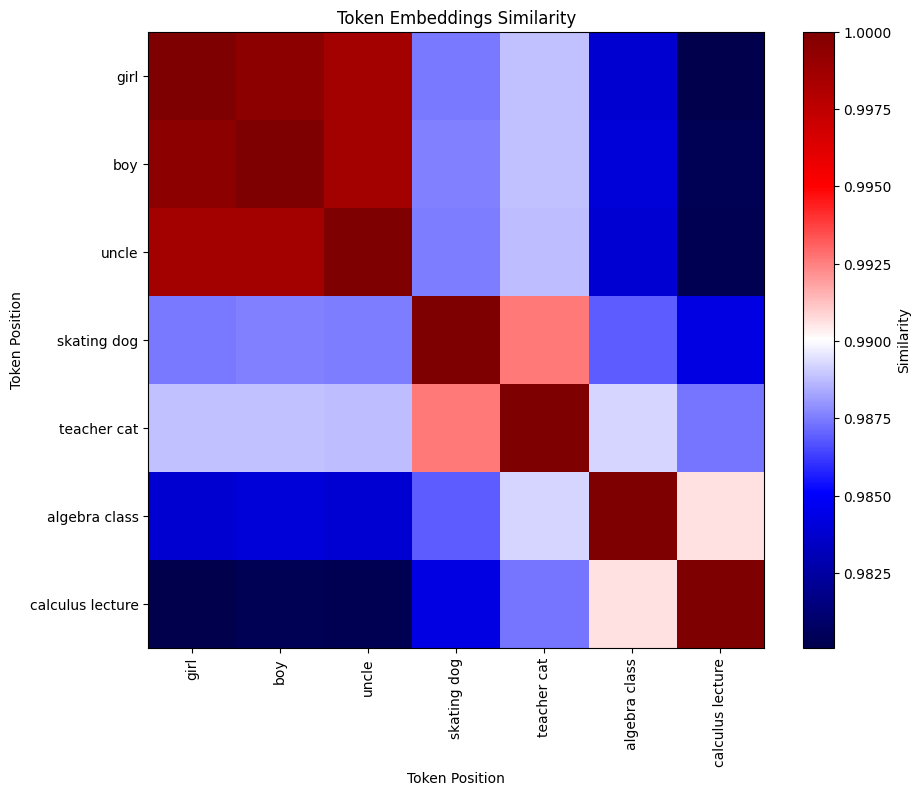

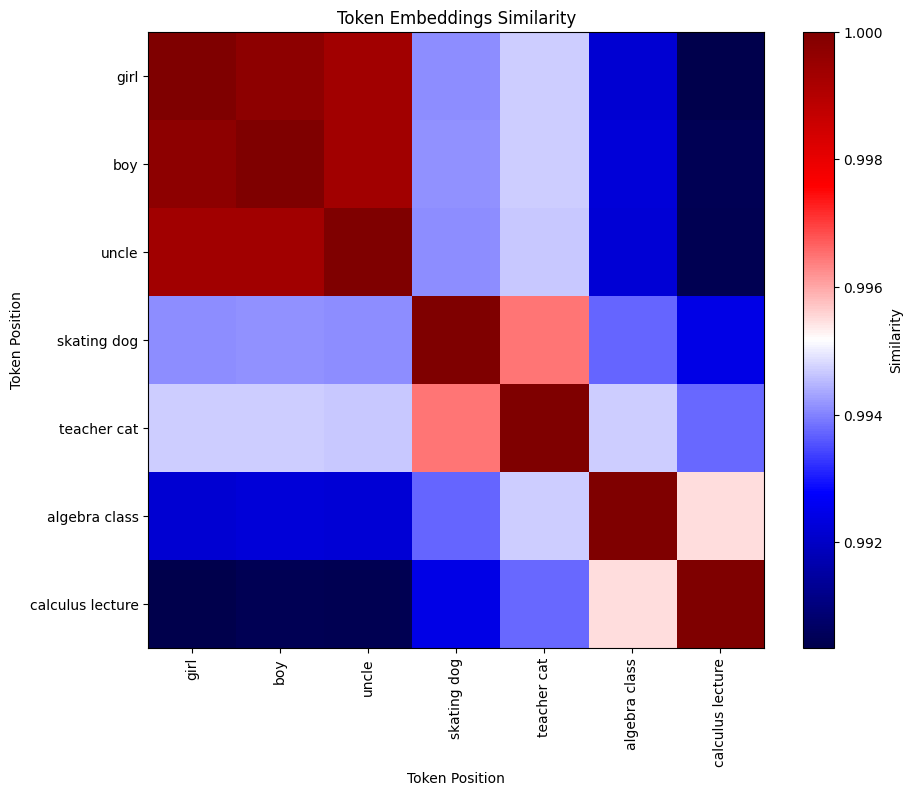

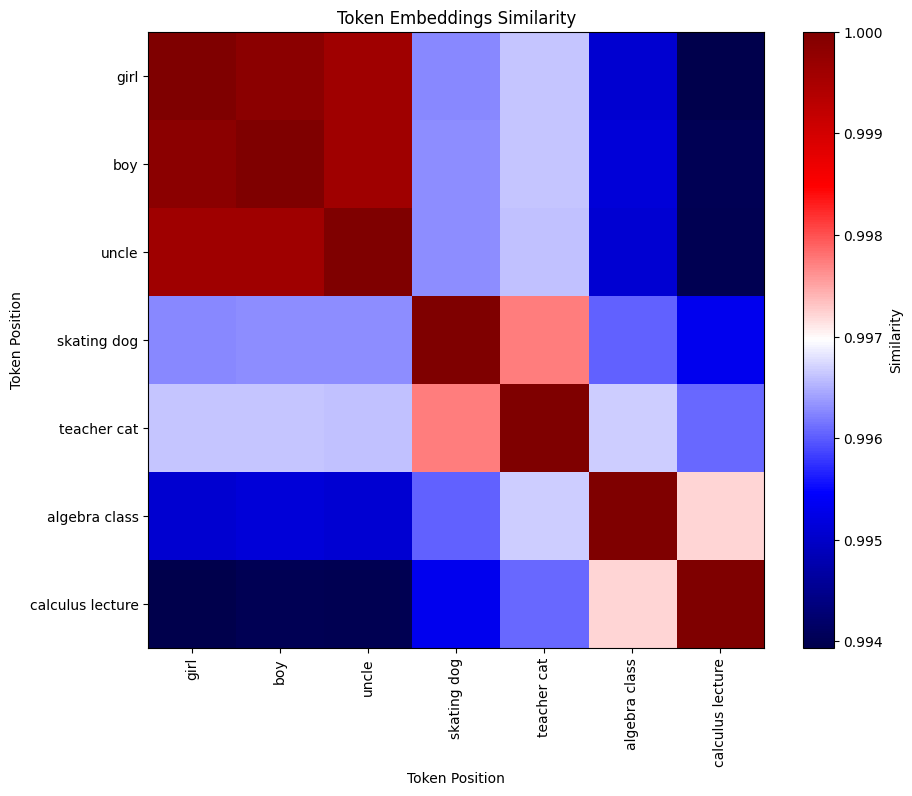

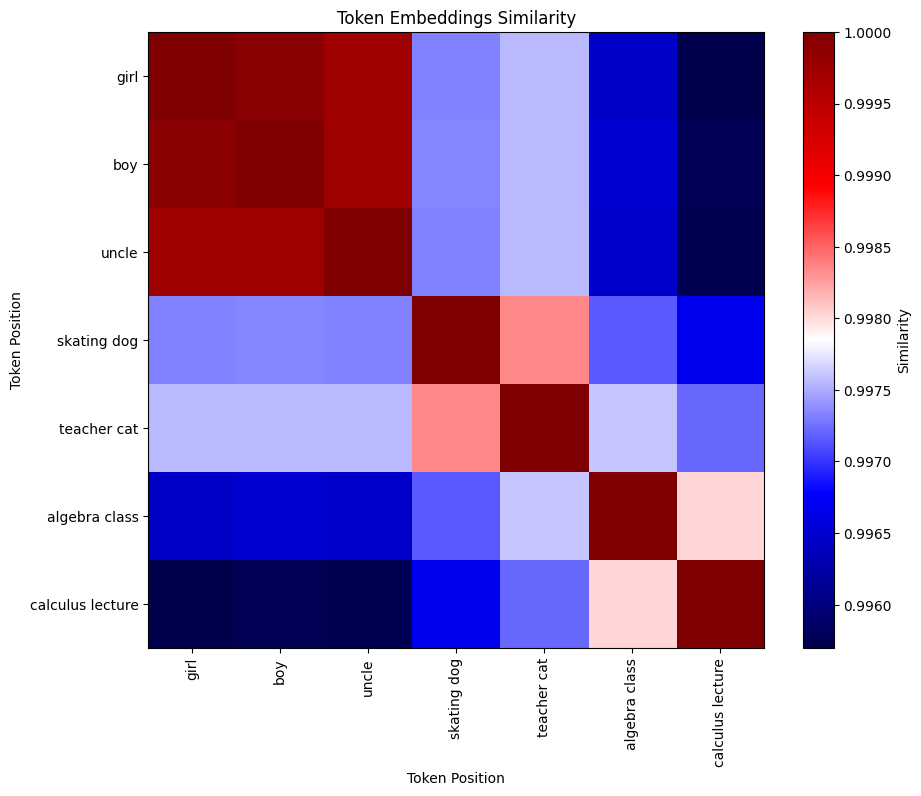

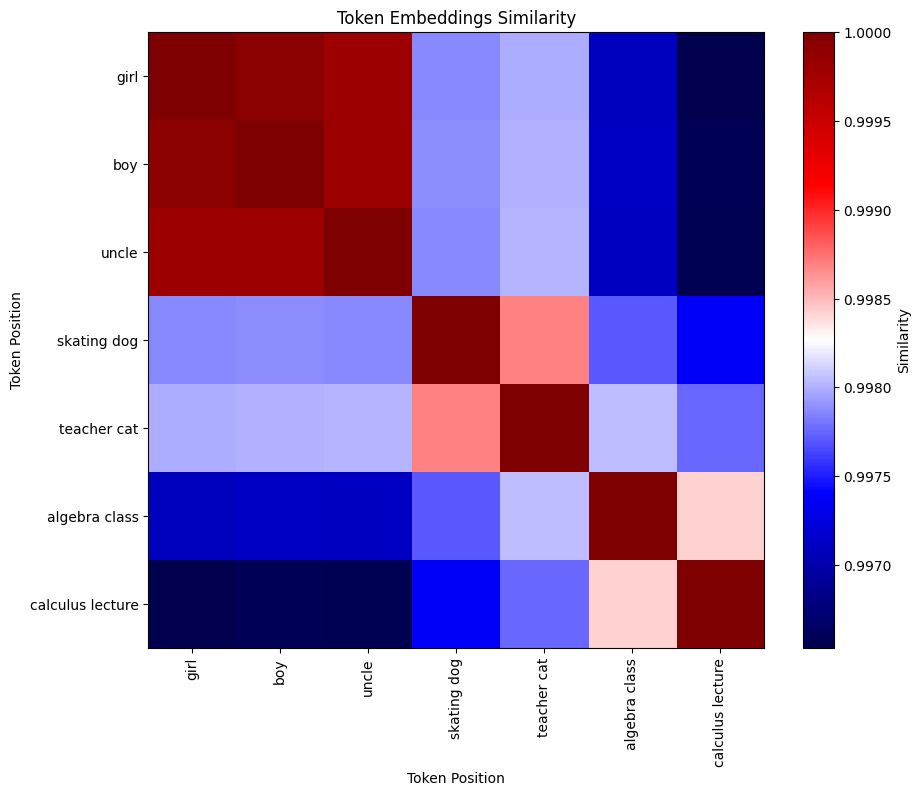

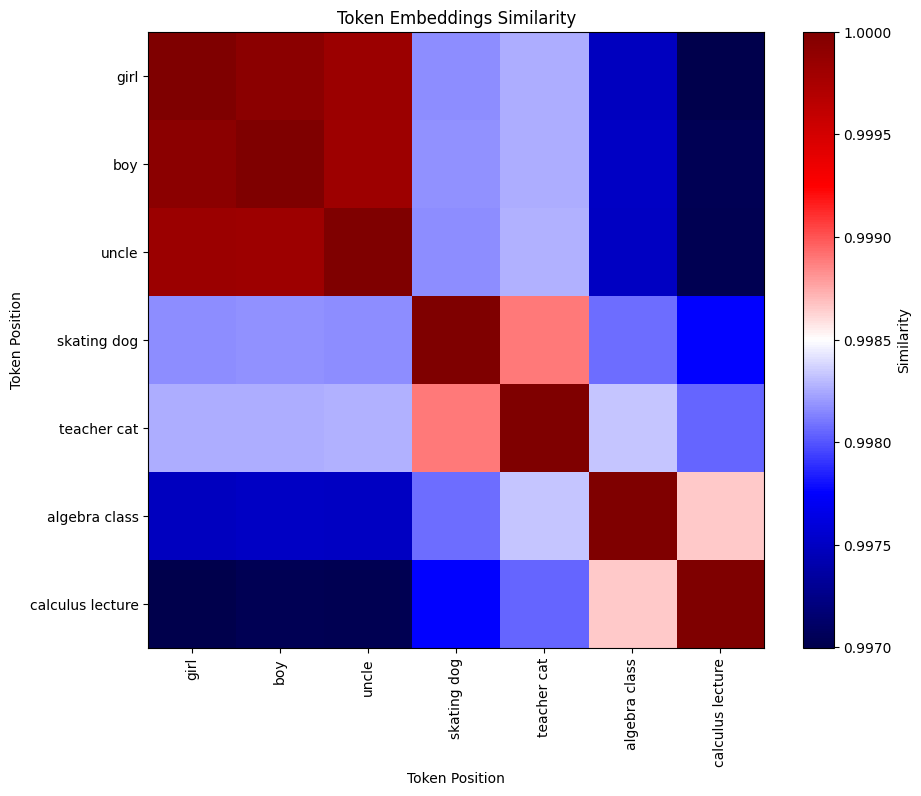

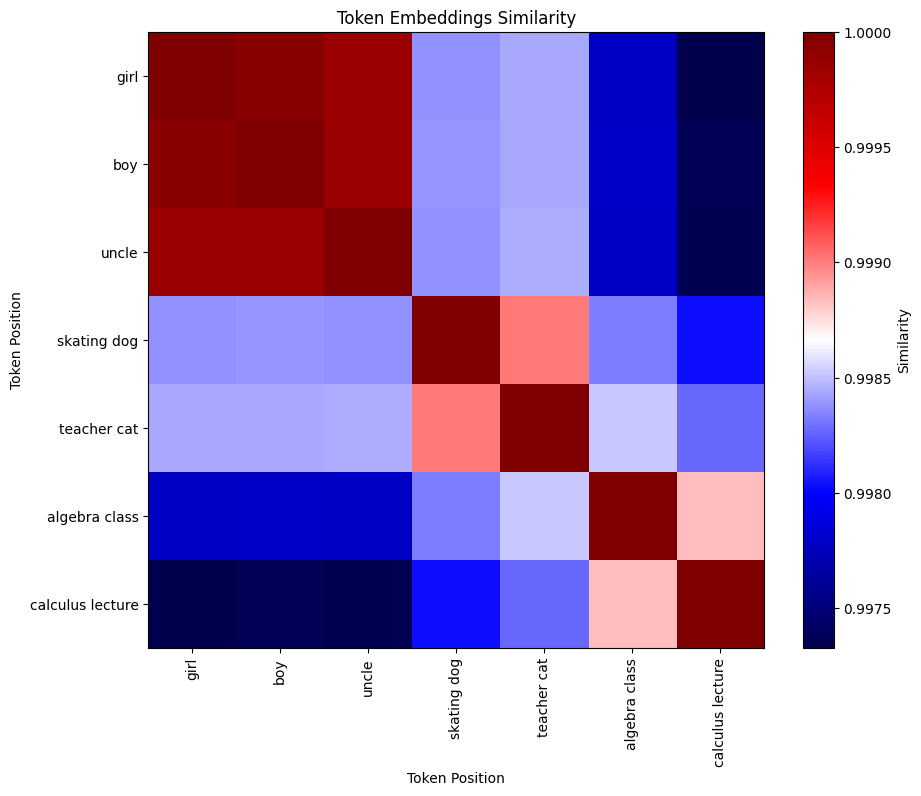

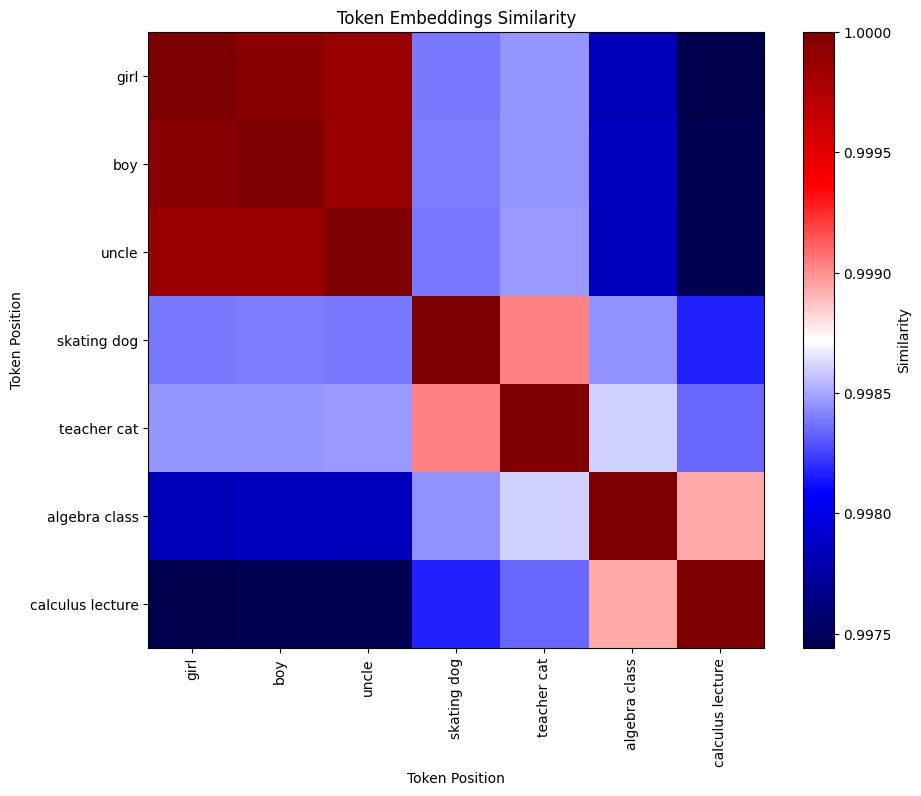

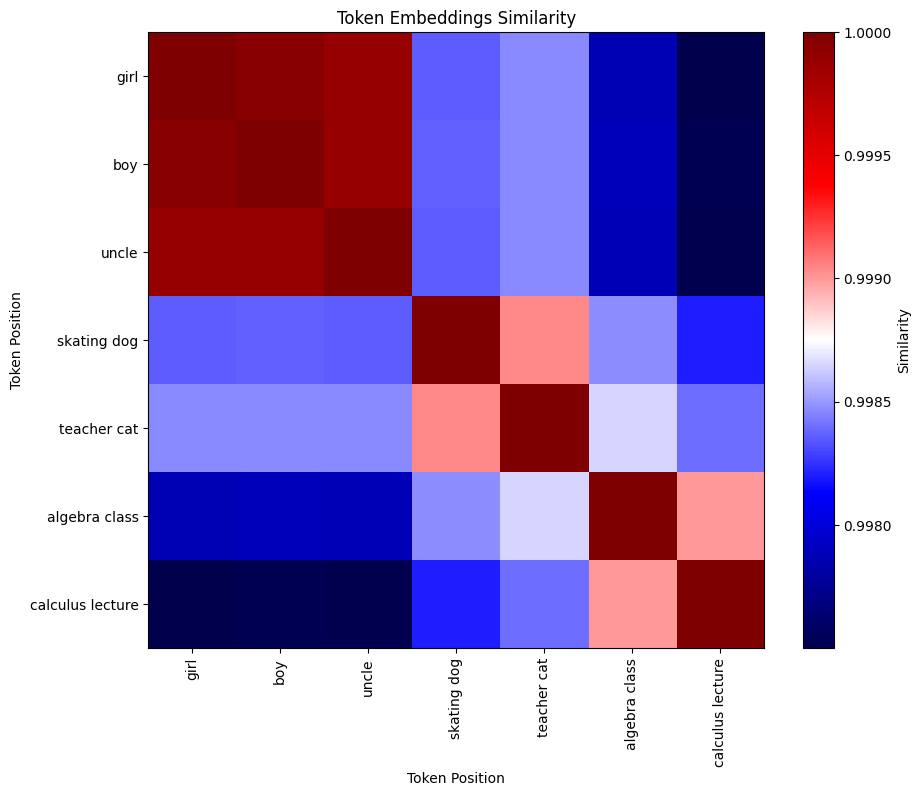

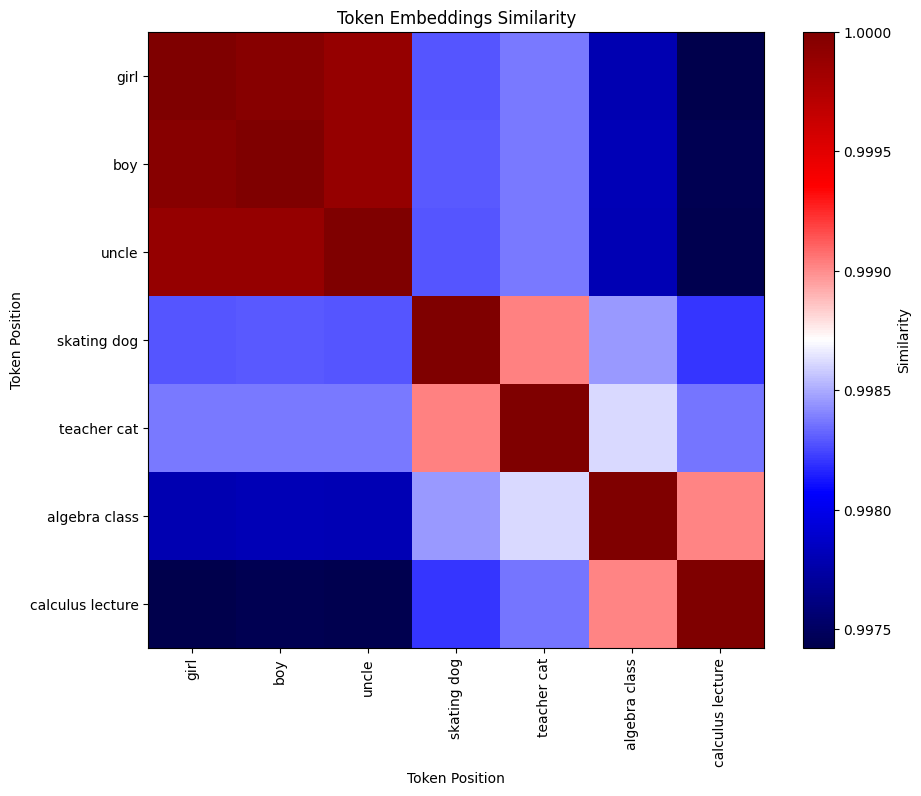

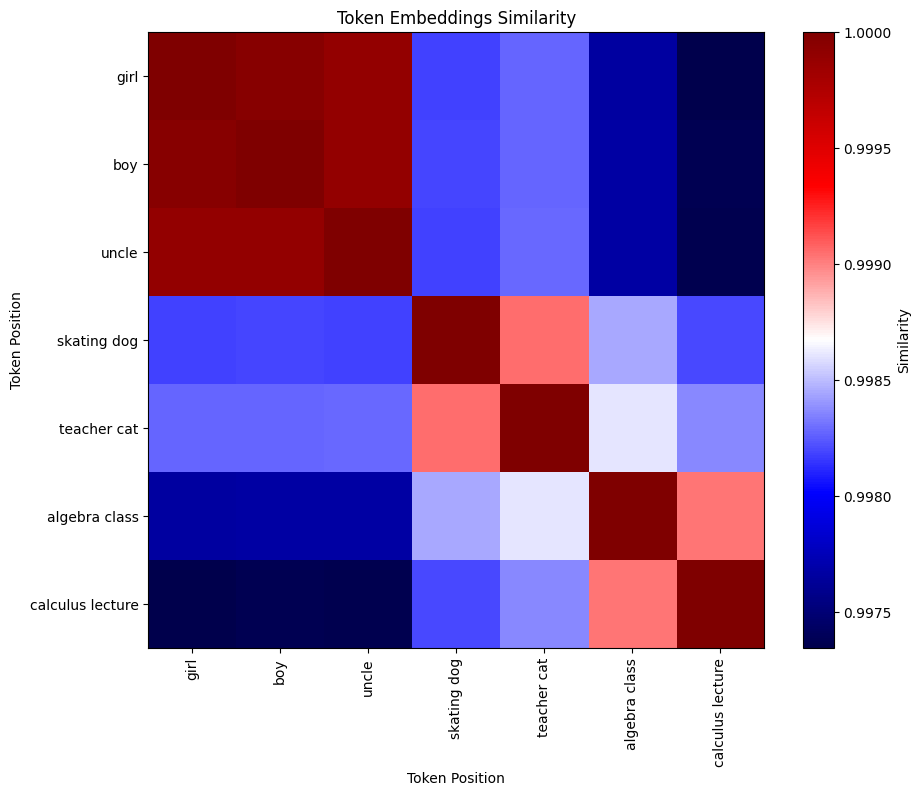

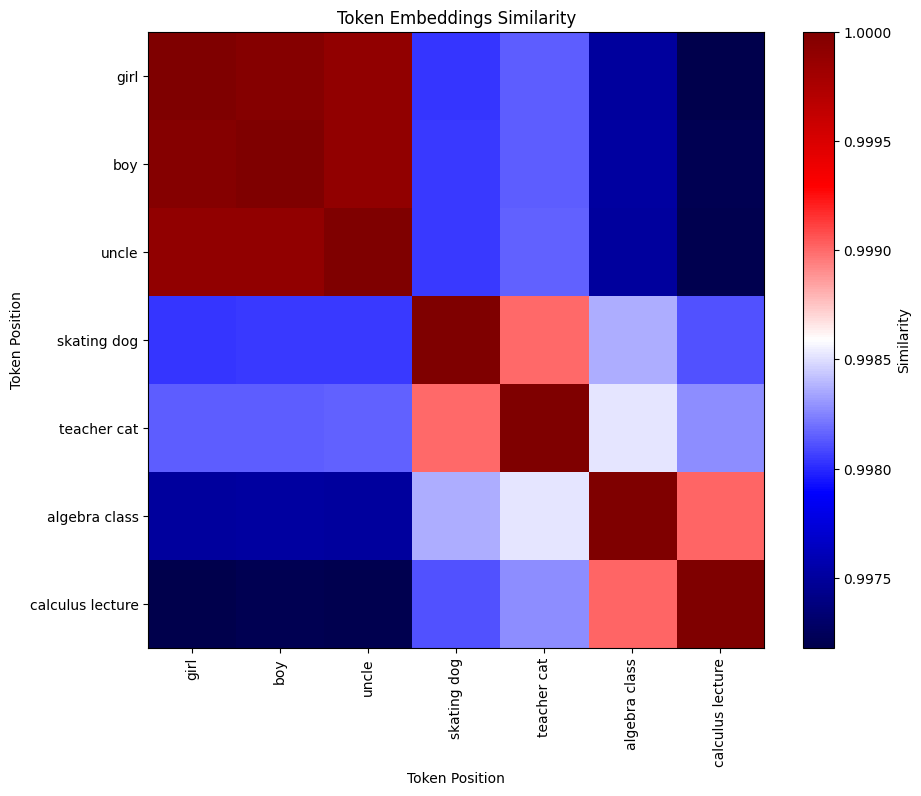

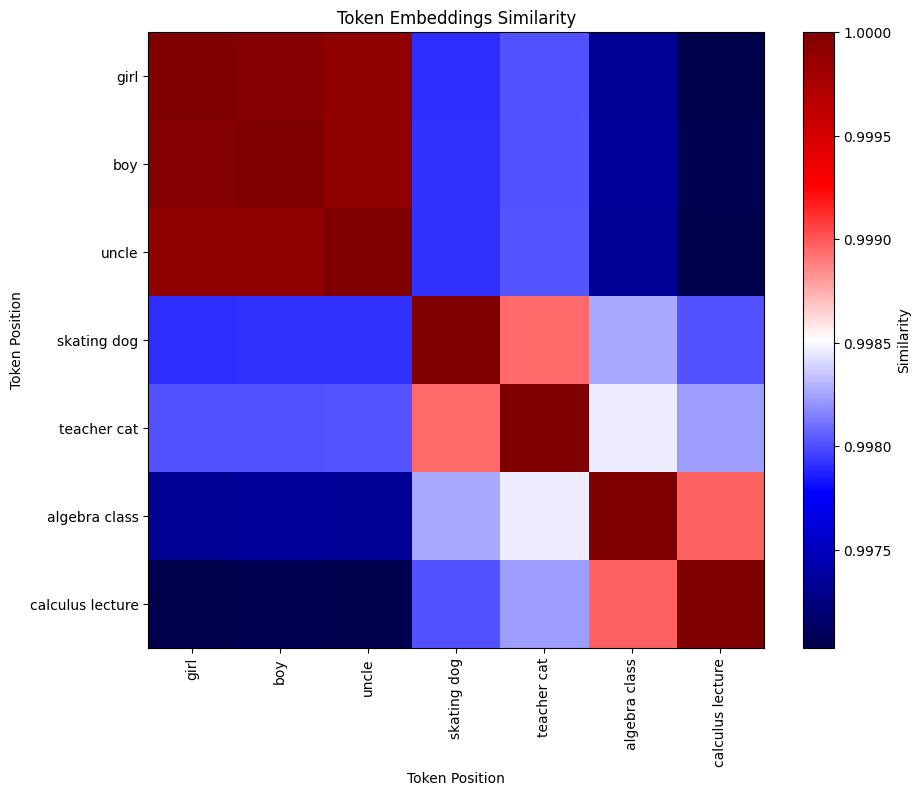

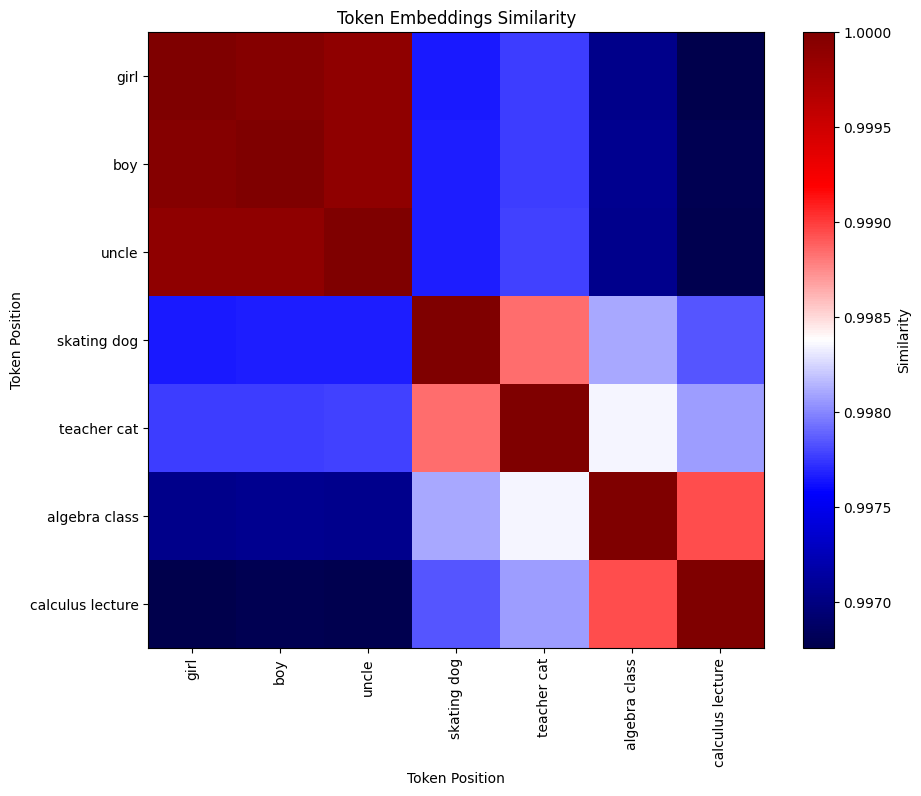

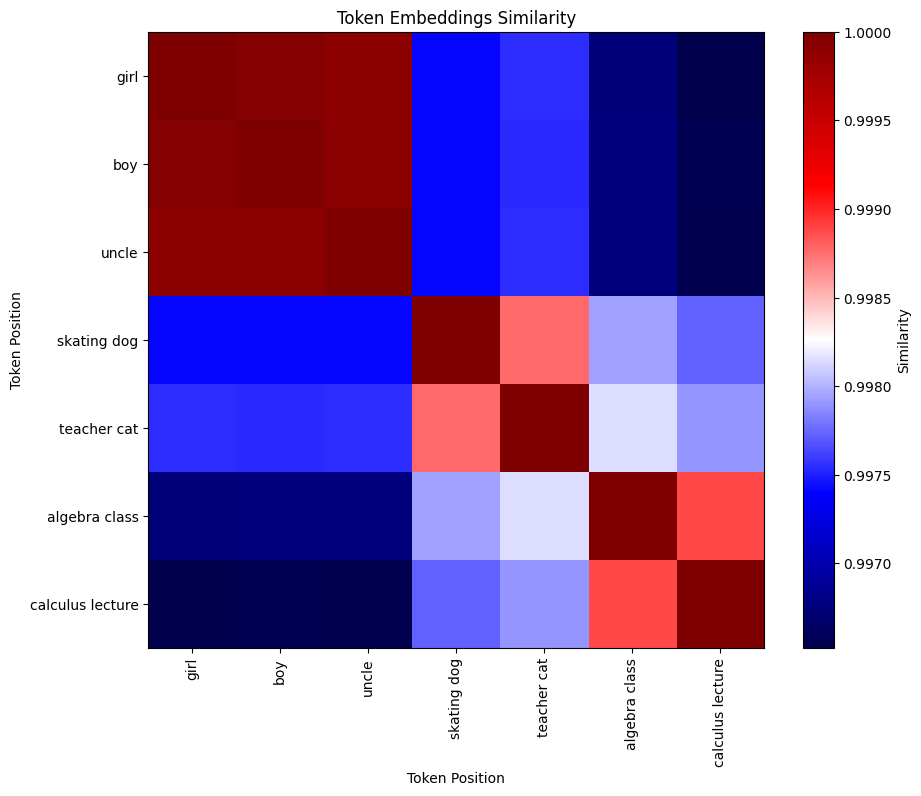

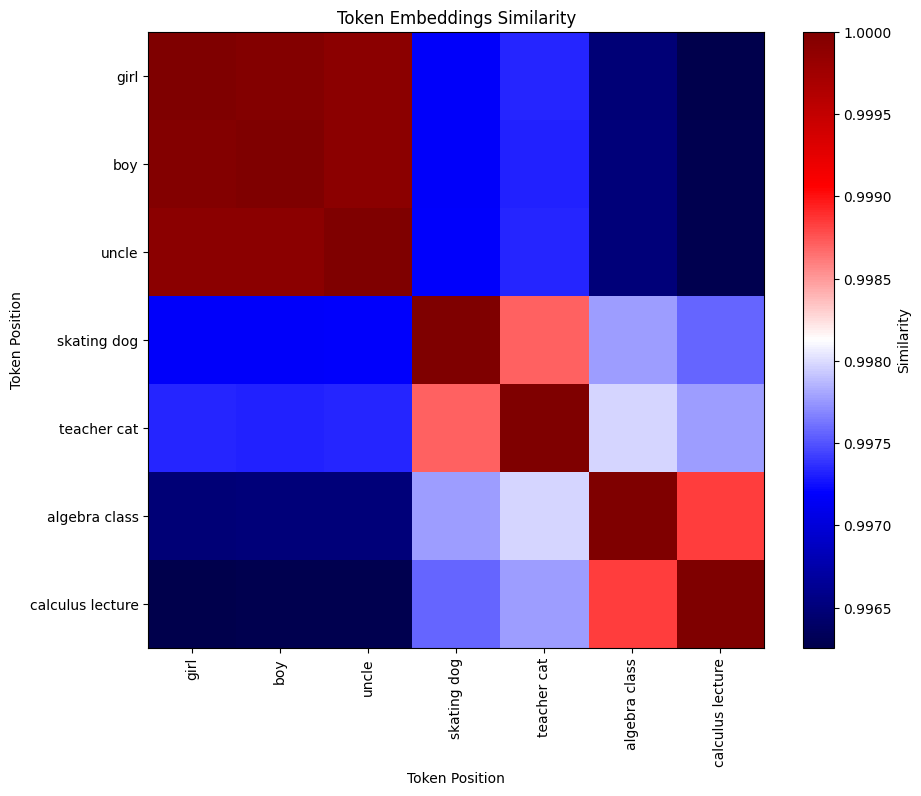

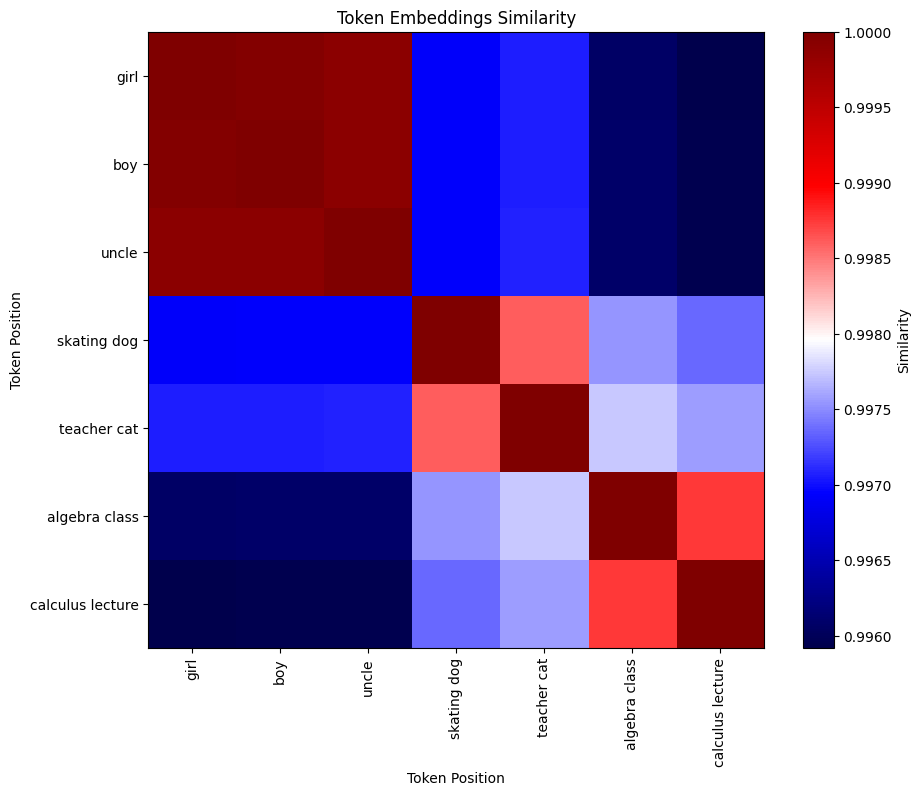

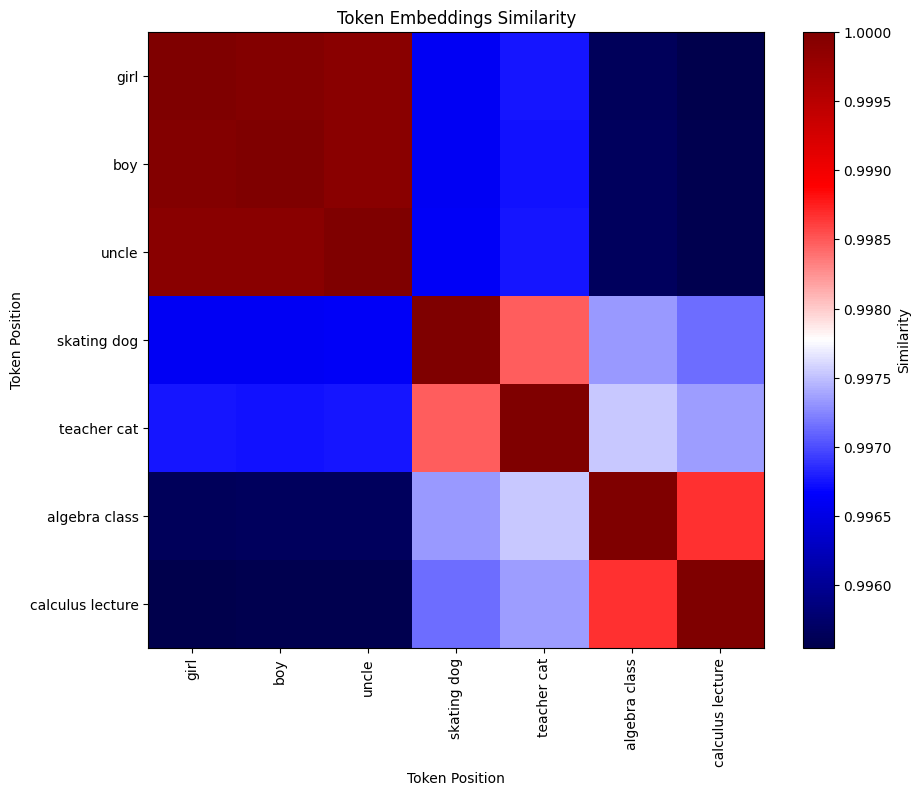

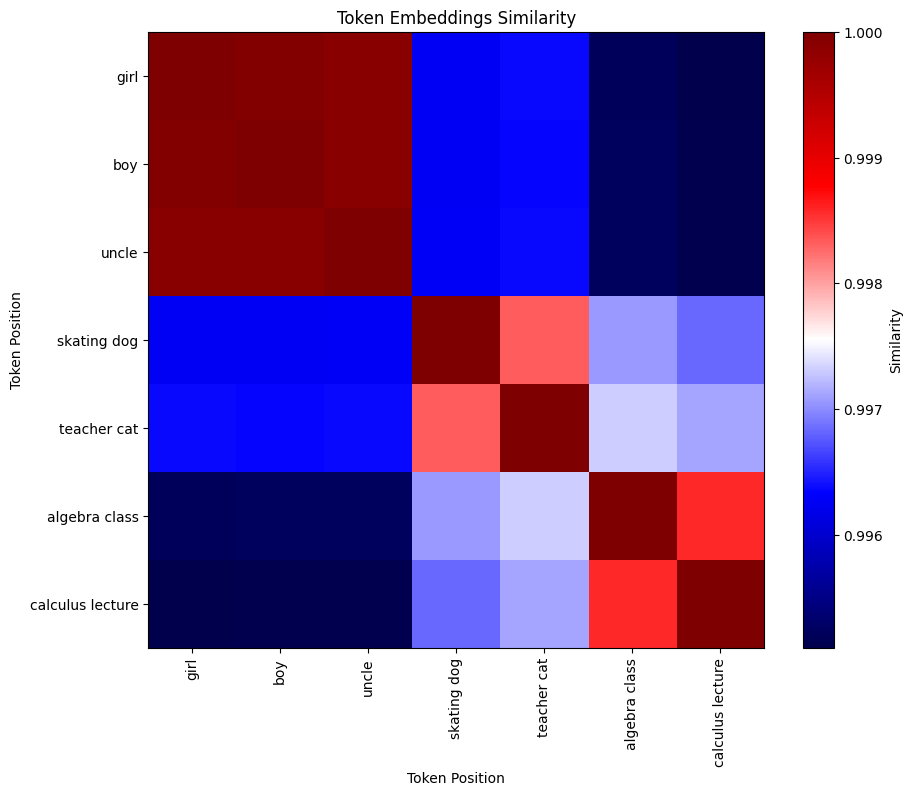

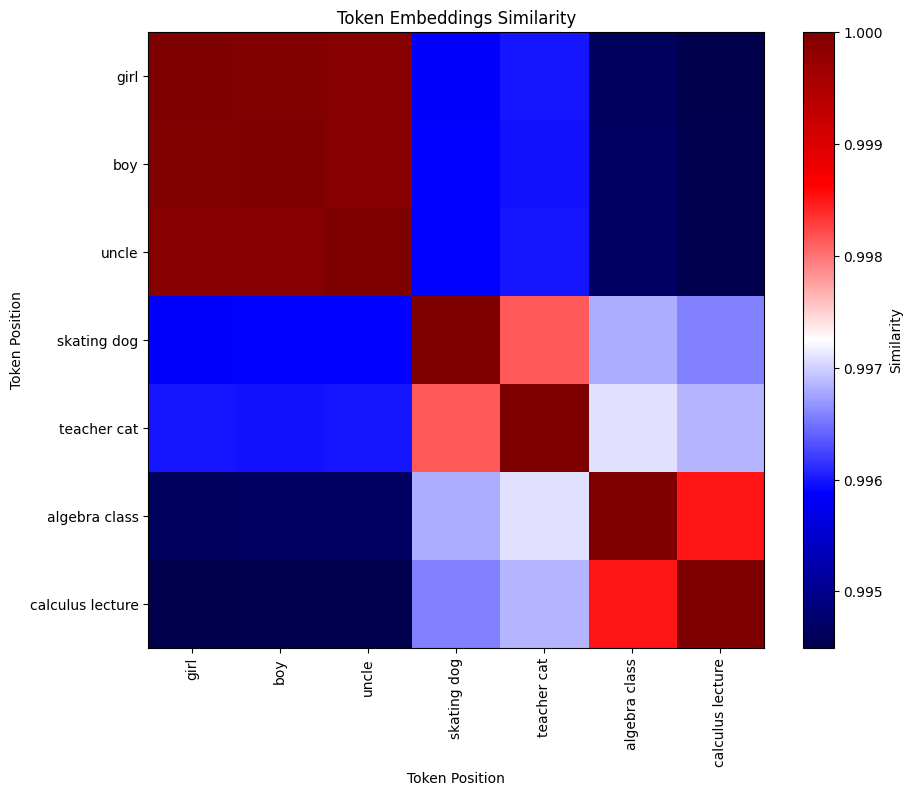

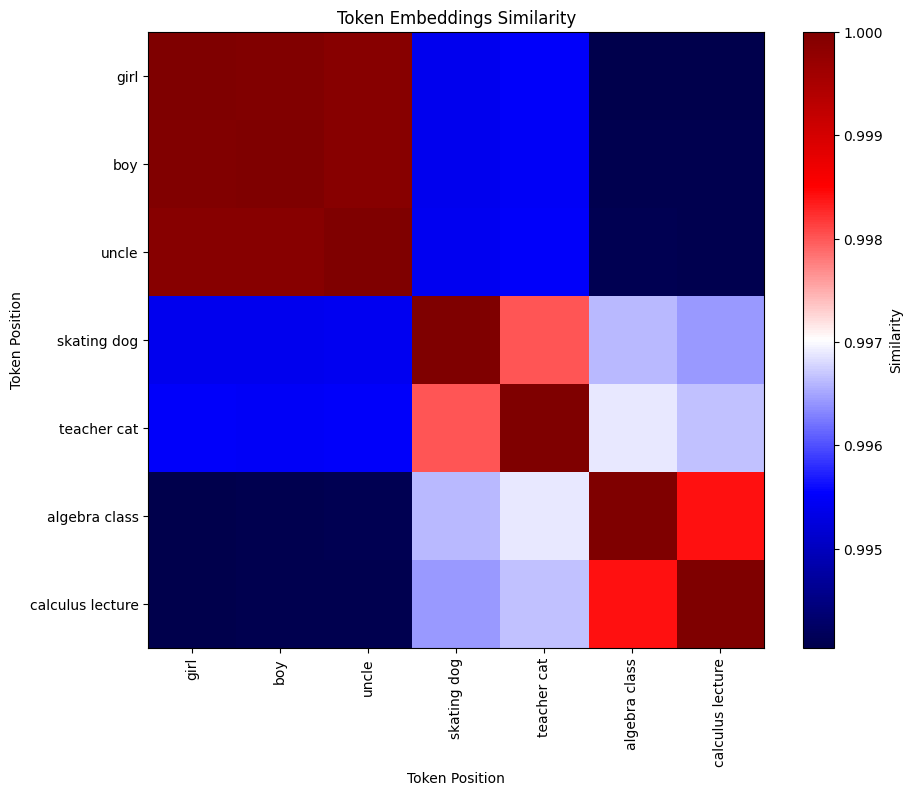

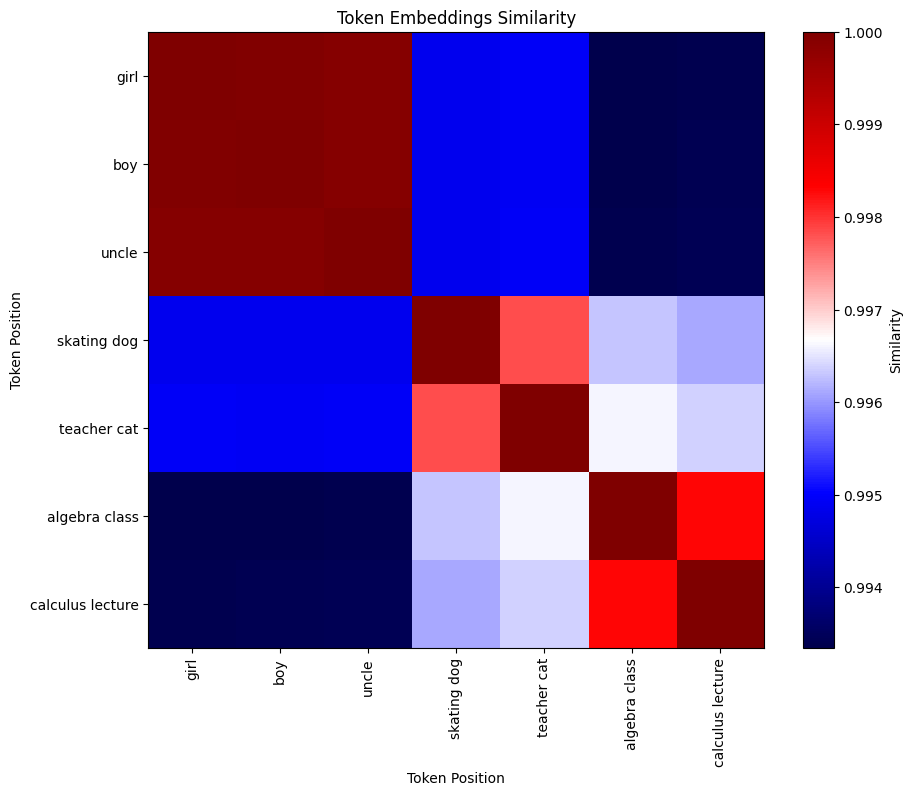

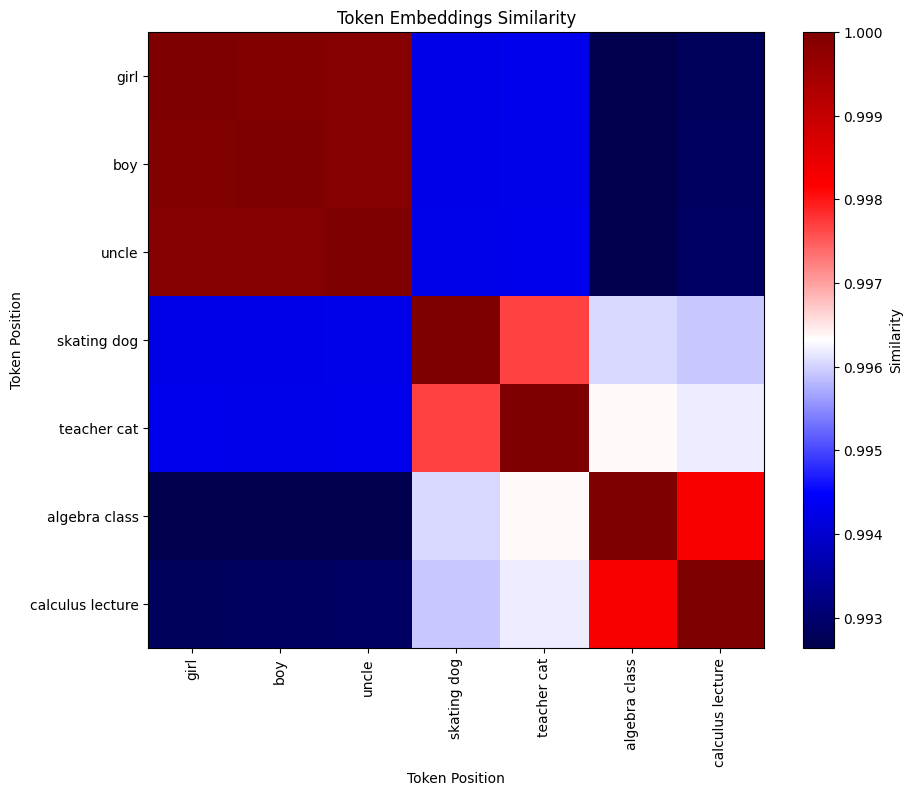

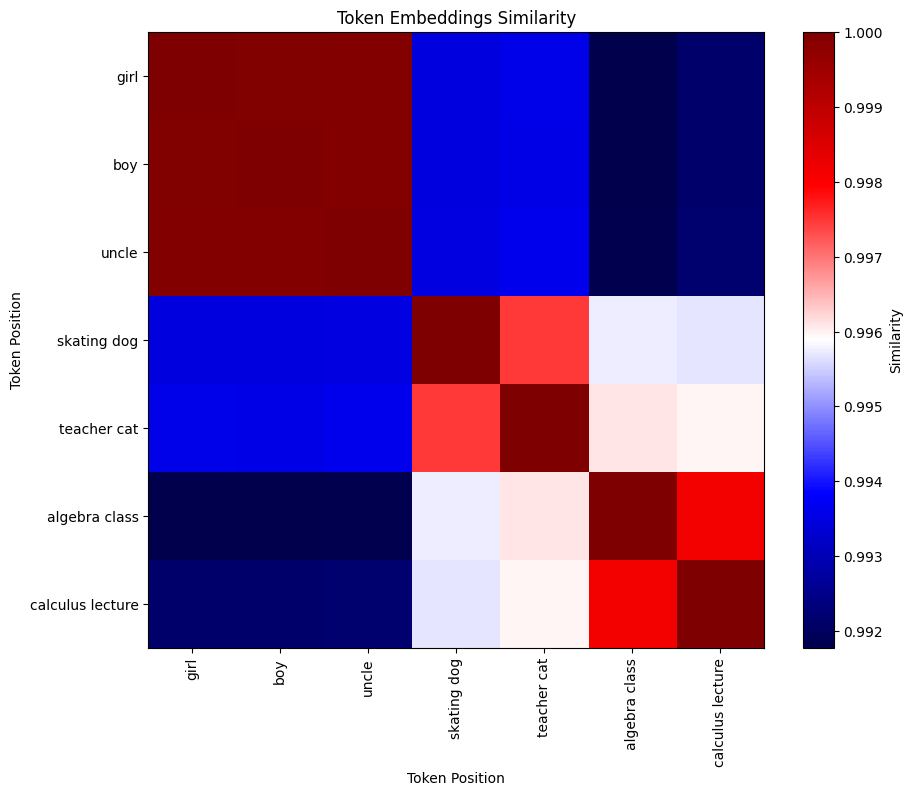

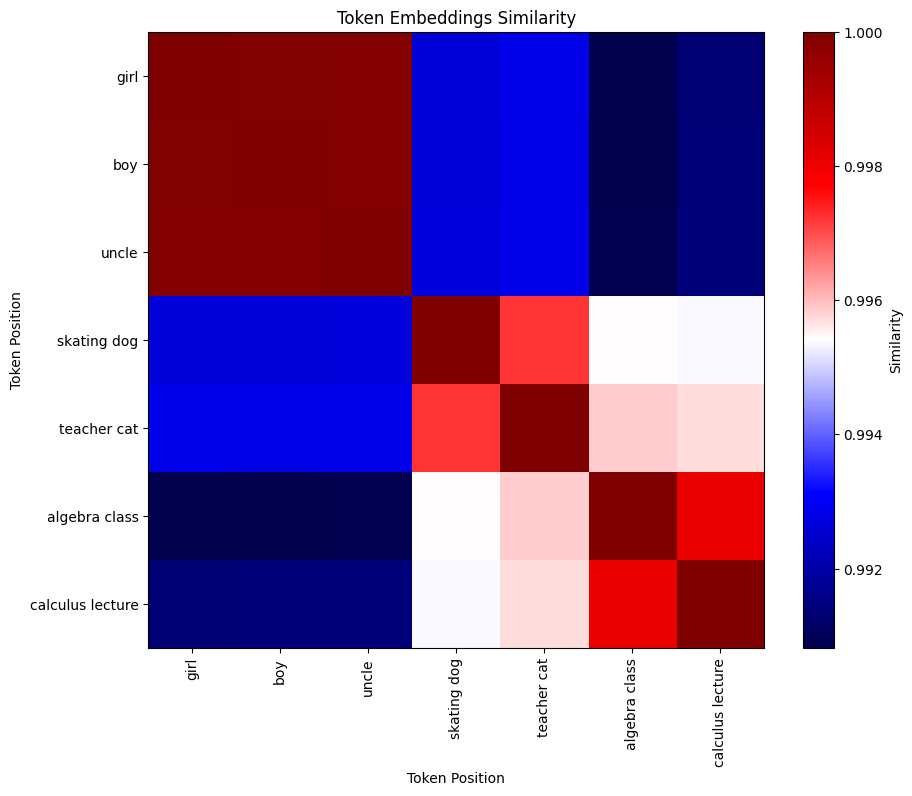

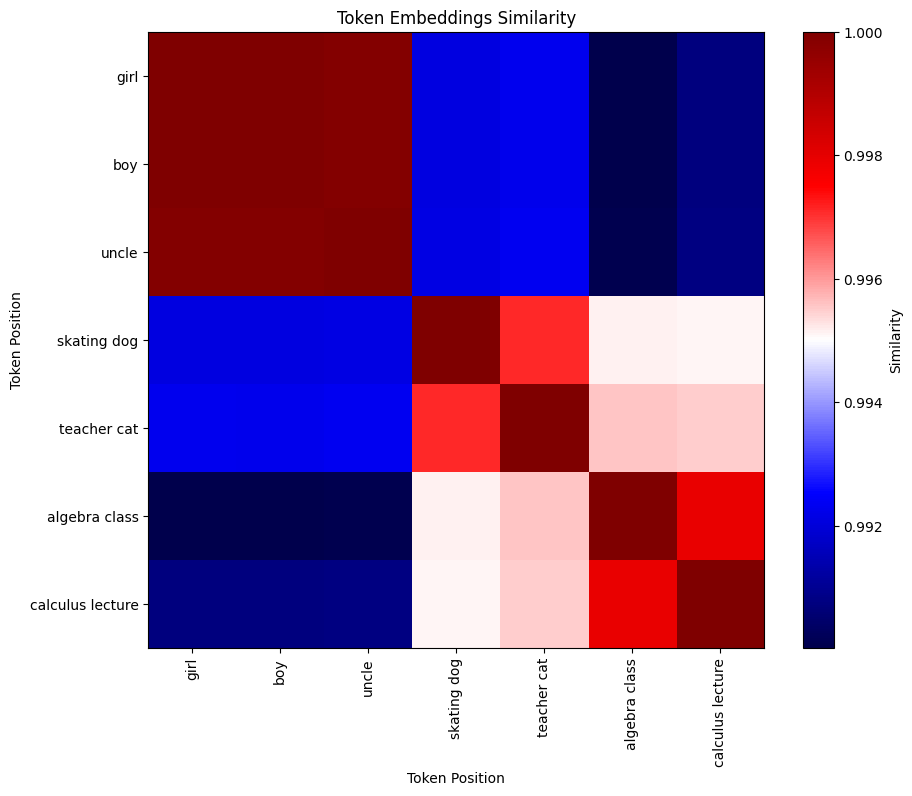

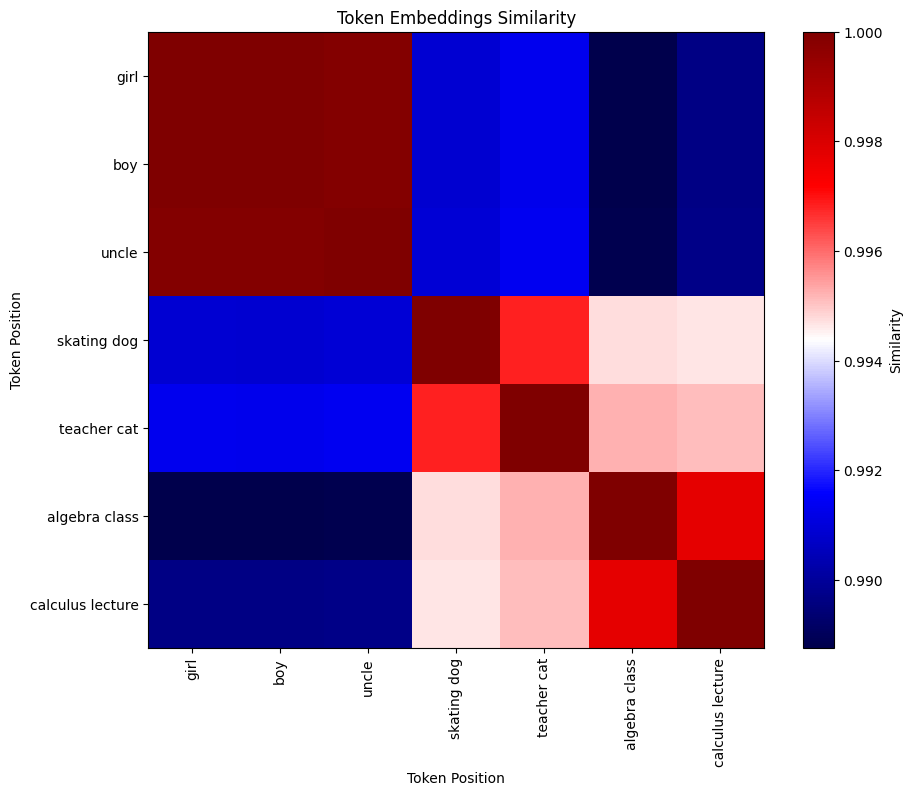

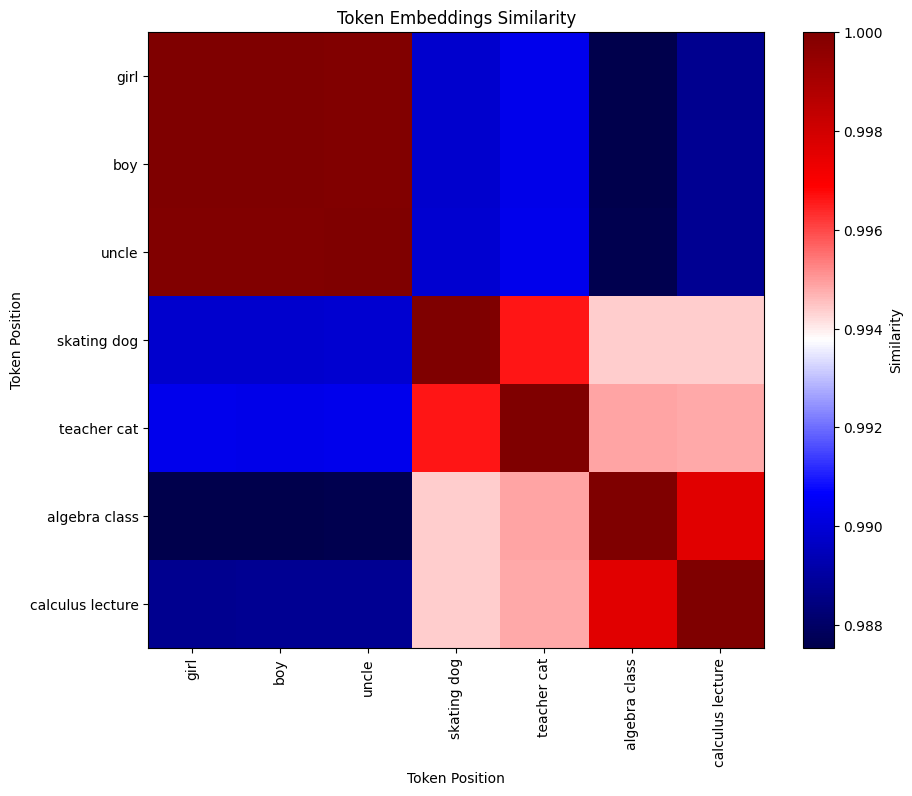

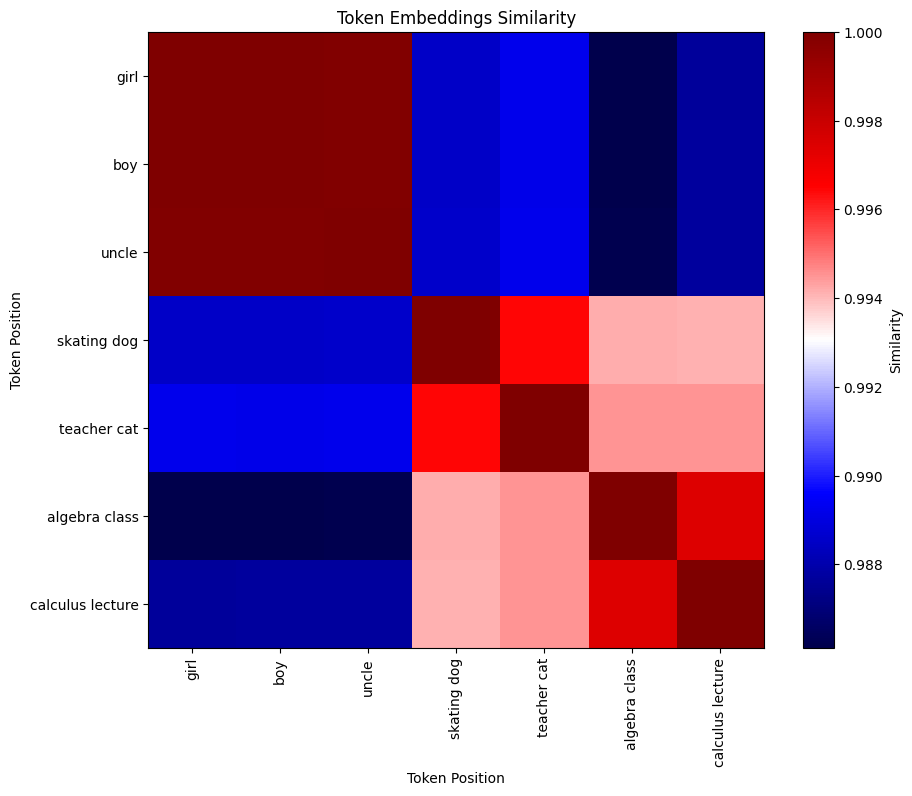

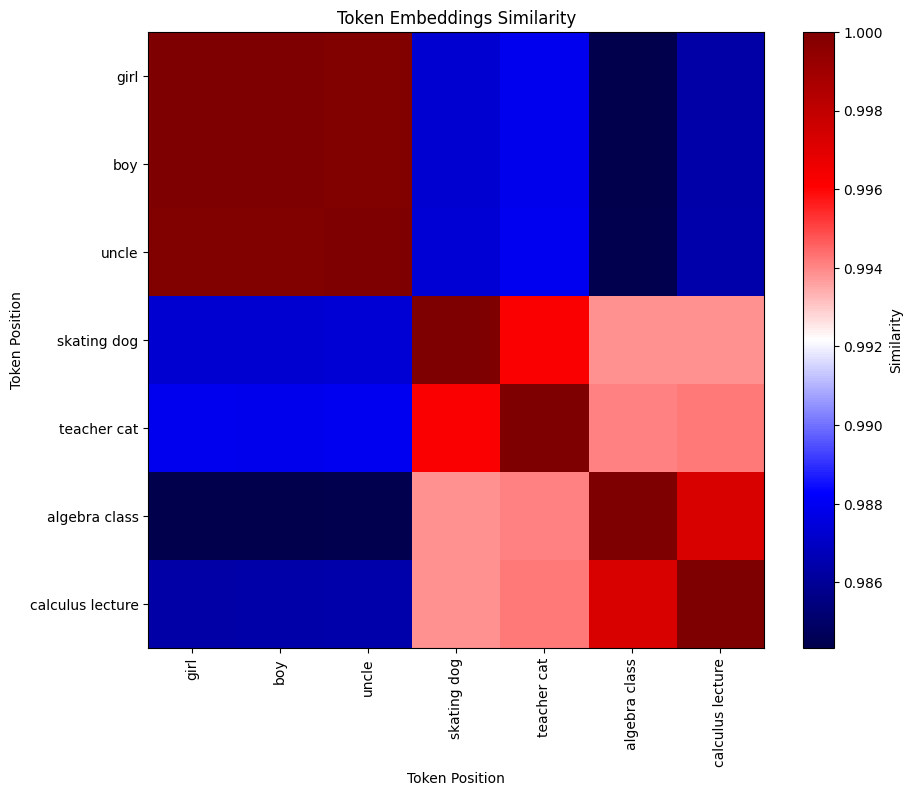

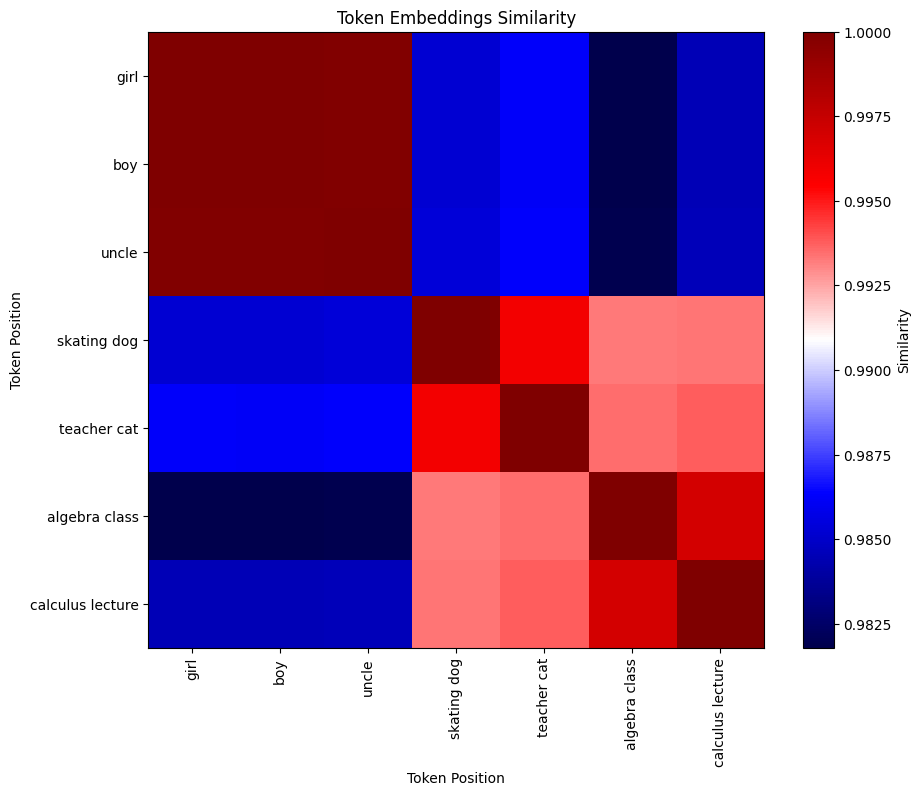

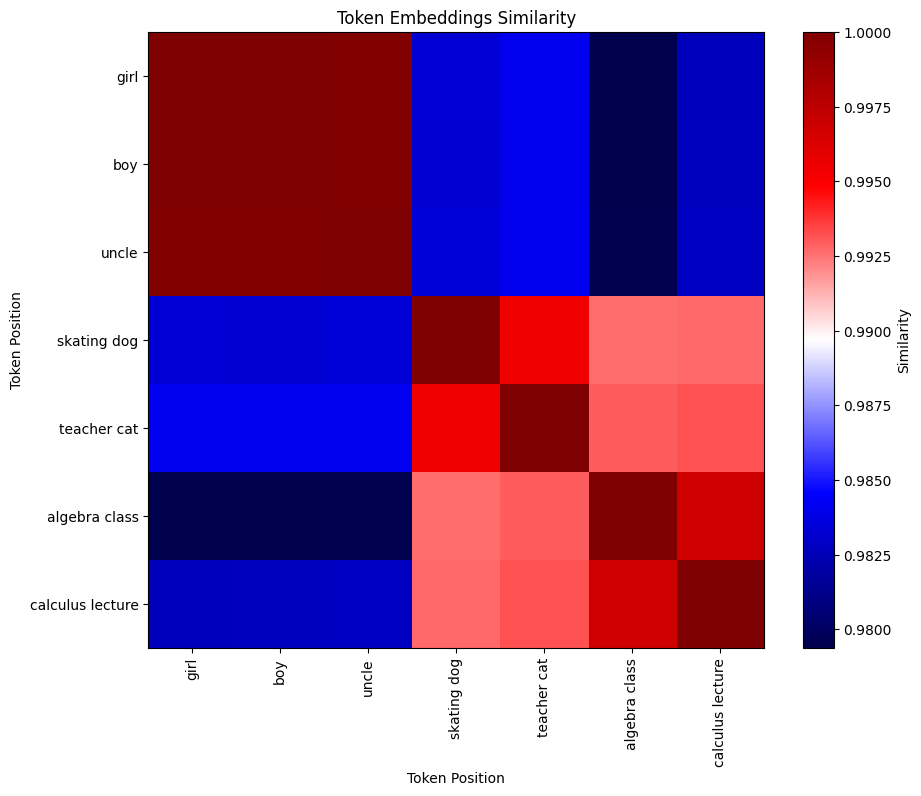

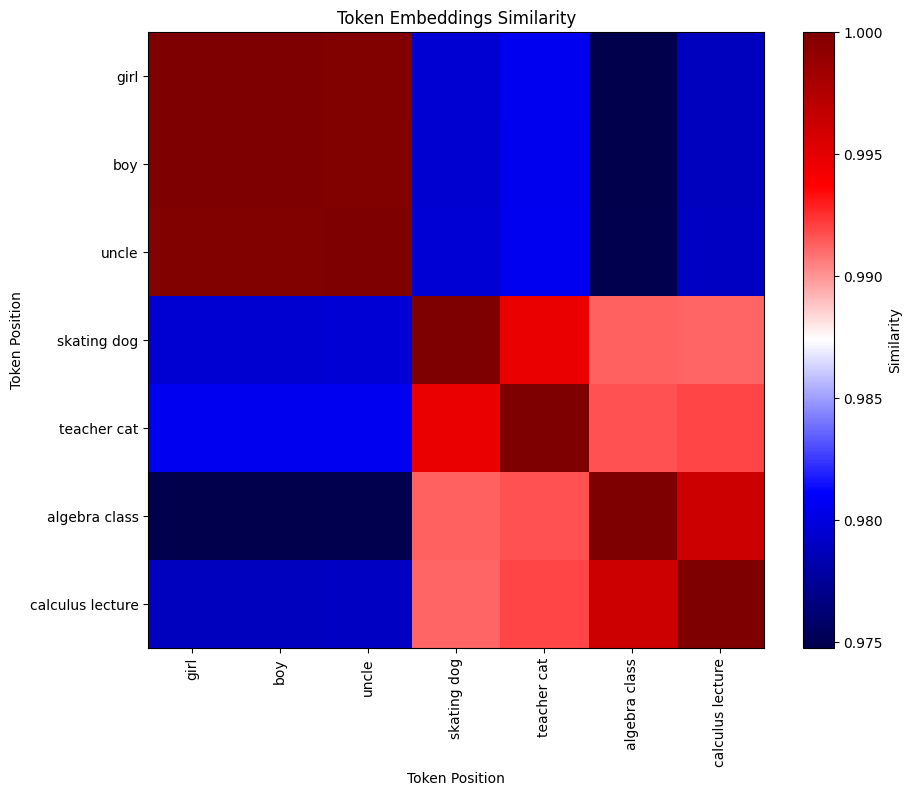

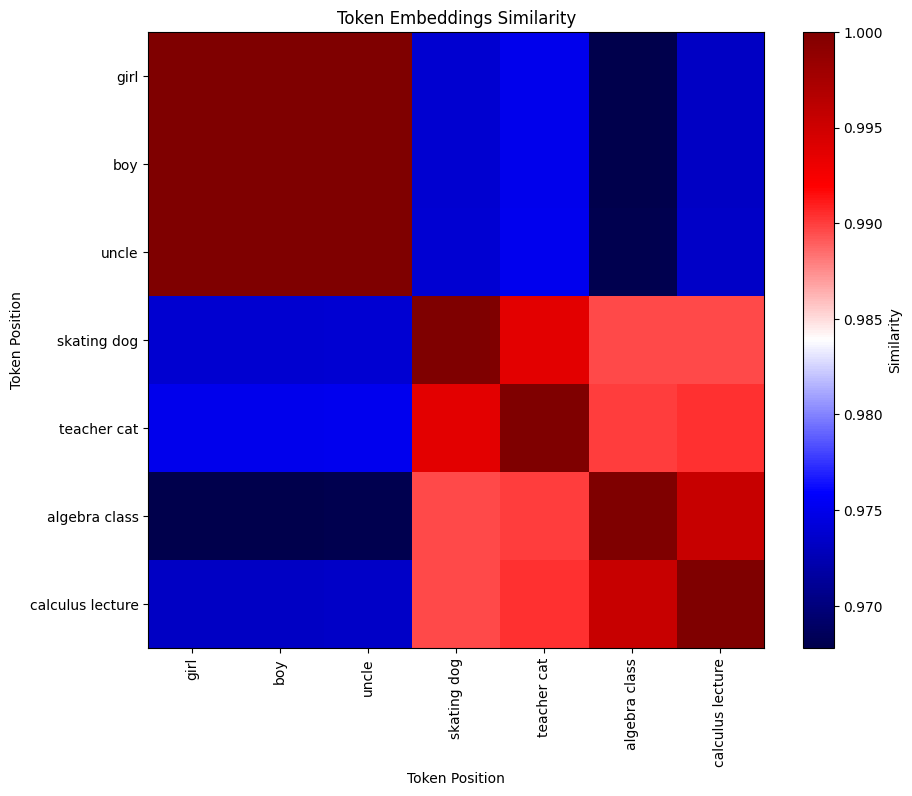

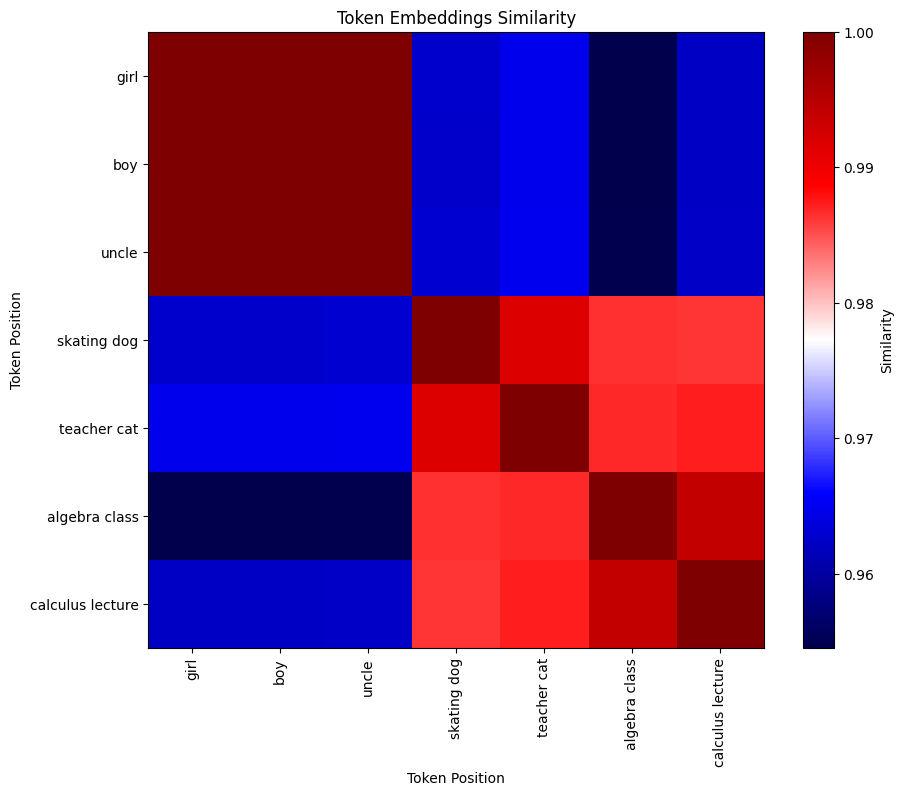

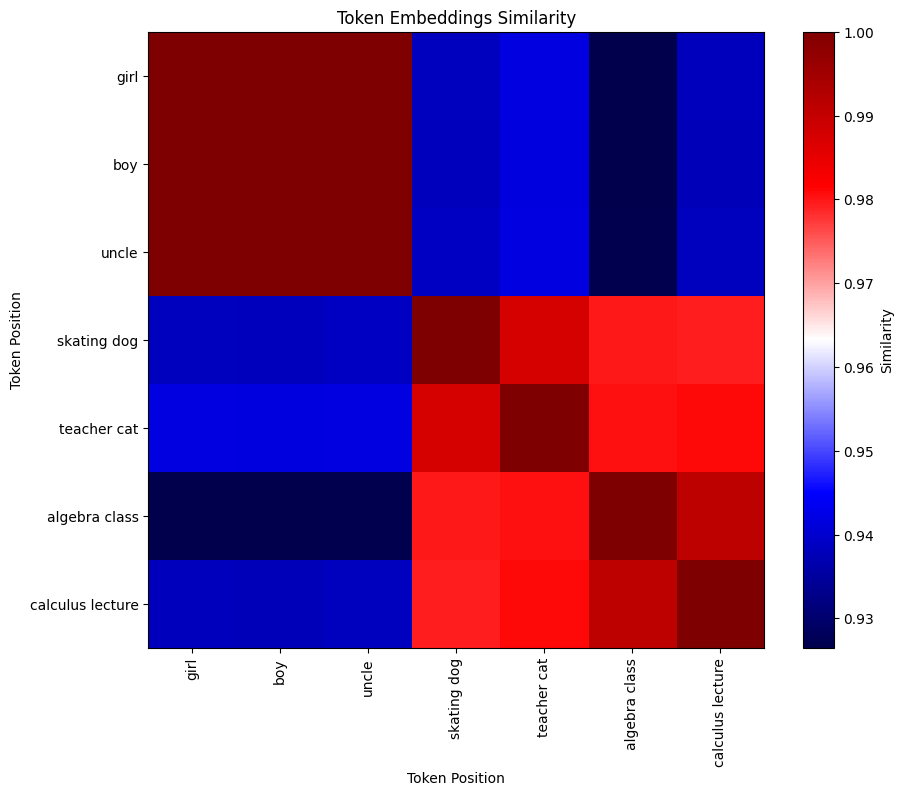

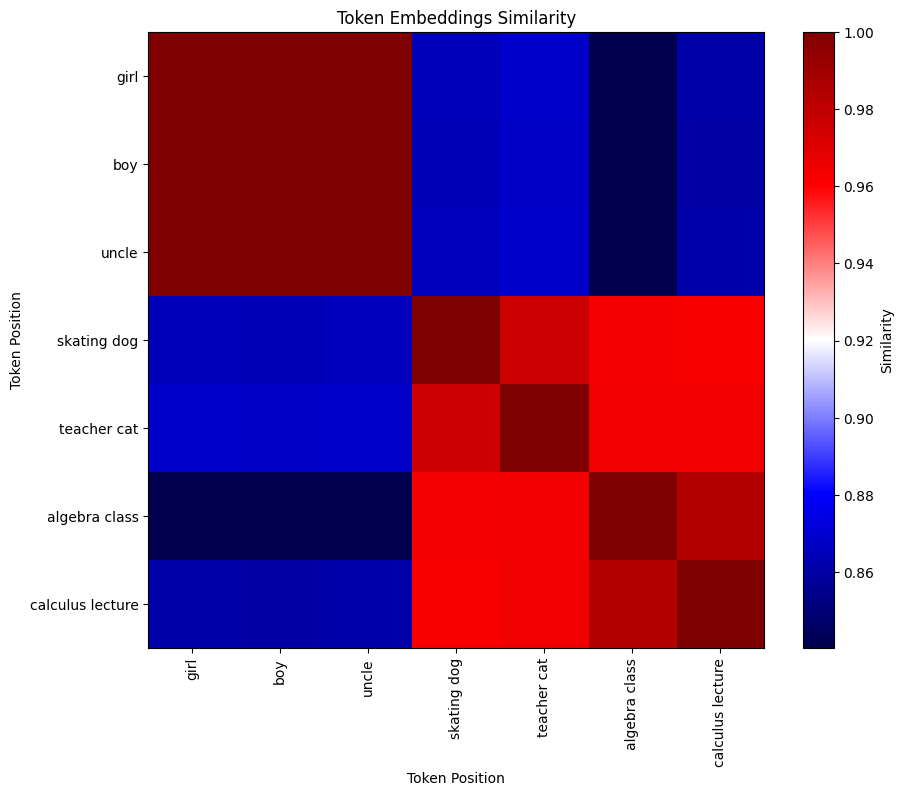

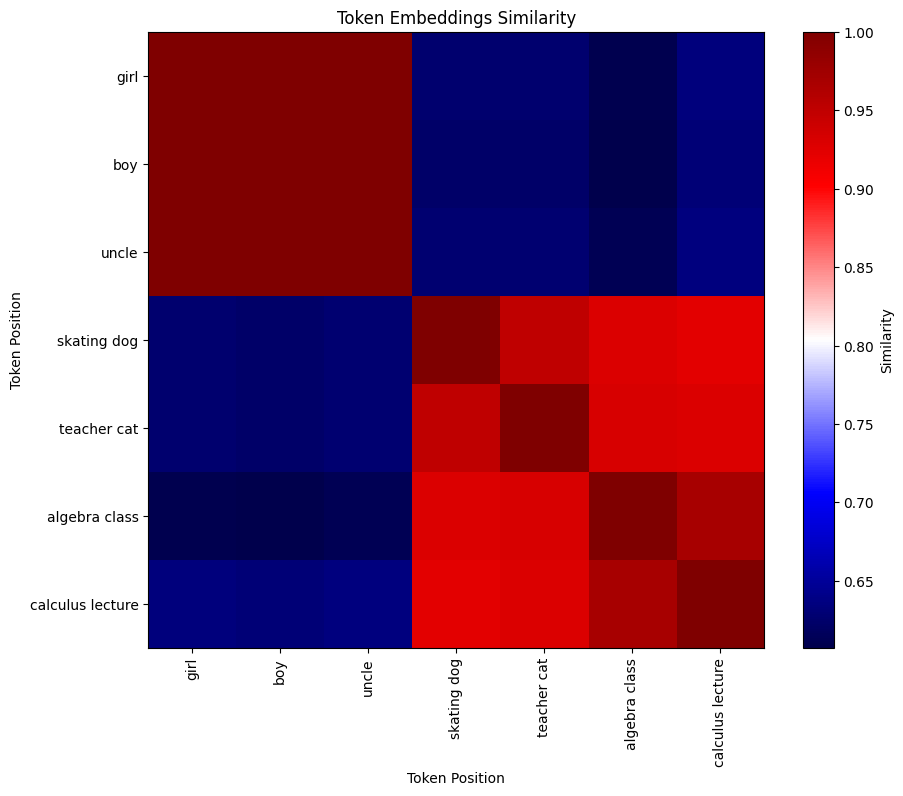

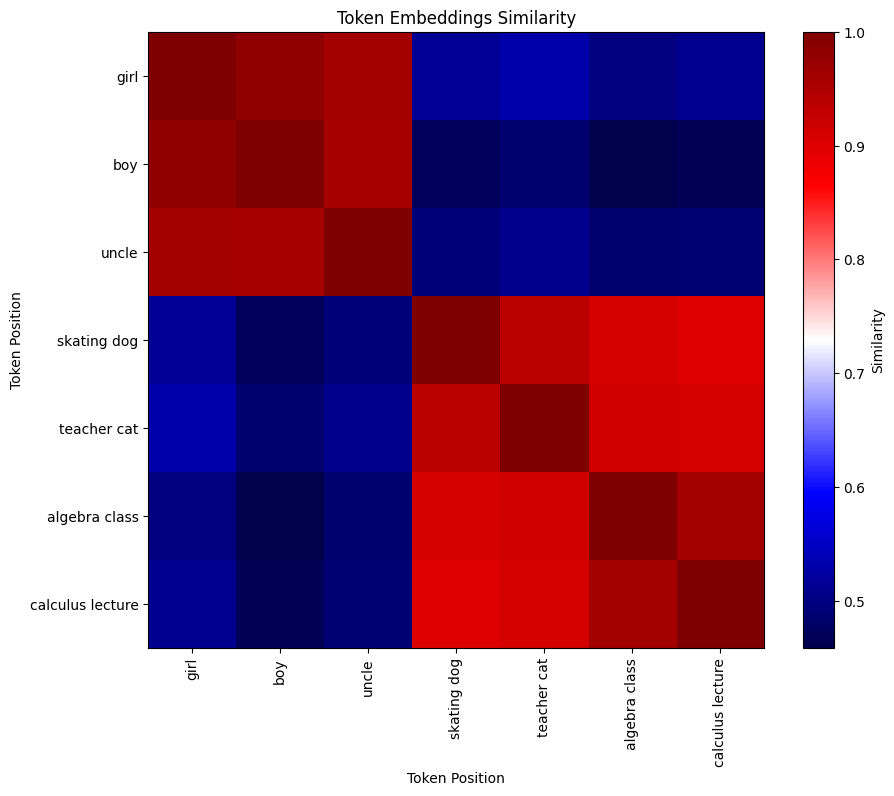

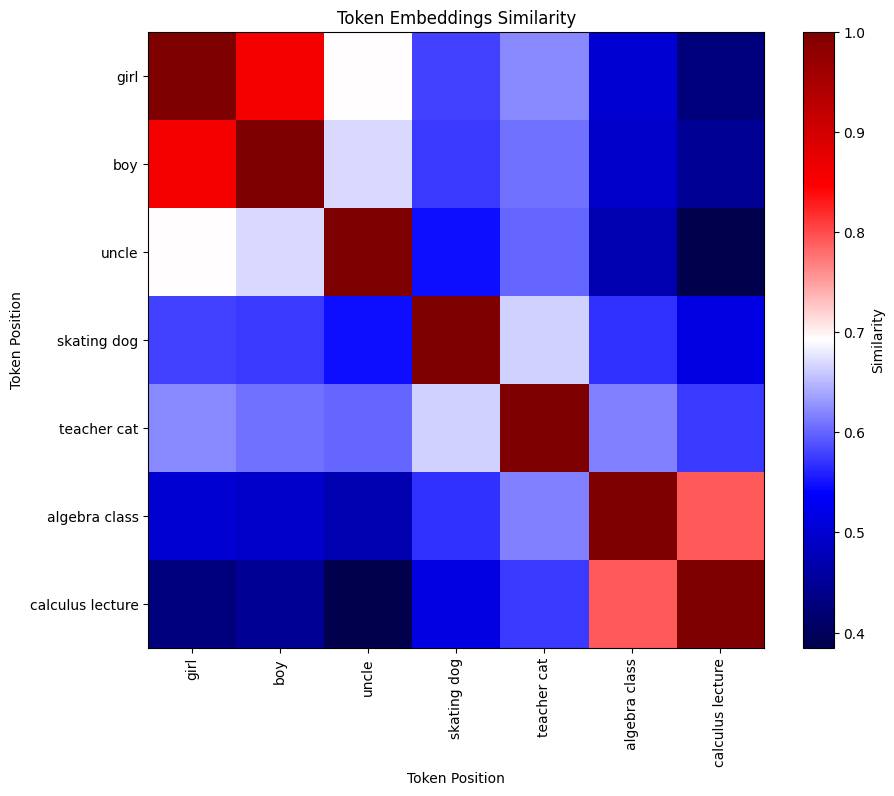

In [113]:
for sim in cosine_similarities:
    plt.figure(figsize=(10, 8))
    make_dist_plot(sim)

In [114]:
embs.shape

torch.Size([49, 7, 1600])

In [115]:
base=[cosine_similarity(layer_embs) for layer_embs in embs]

In [116]:
def interpolate(m):
    ans=[]
    for x1,x2 in zip(m[:-1],m[1:]):
        ans.append(x1)
        ans.append((x1+x2)/2)
    ans.append(m[-1])
    return ans

In [117]:
frame_data=base
frame_data.append(base[-1]) #hold last image longer
for _ in range(2):
    frame_data=interpolate(frame_data)

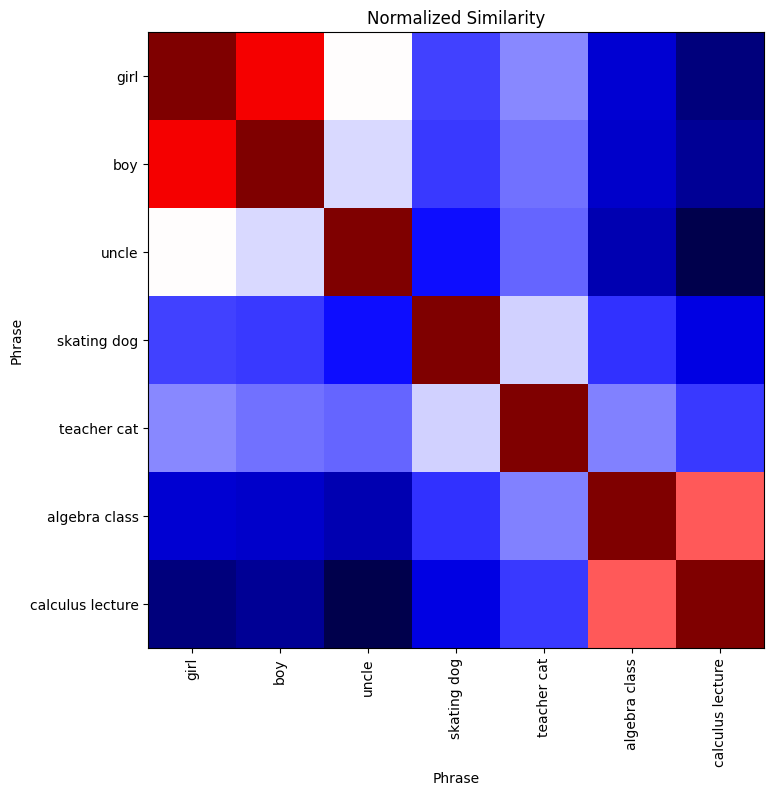

In [118]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(10, 8))
frames =  [[plt.imshow(d, cmap='seismic',animated=True)] for d in frame_data]
#plt.colorbar(label='Similarity')
plt.title('Normalized Similarity')
plt.xlabel('Phrase')
plt.ylabel('Phrase')
plt.xticks(ticks=np.arange(len(phrases)), labels=phrases, rotation=90)
plt.yticks(ticks=np.arange(len(phrases)), labels=phrases)
plt.show()

ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True,
                                  repeat_delay=1000)

In [119]:
ani.save('anim.mp4')